<a href="https://colab.research.google.com/github/sdave-connexion/Hierarical-sales-forecsting/blob/main/univariate_timeseries_using_prophet_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Time Series forecasting using Facebook's Prophet


Goal is to do timeseries analysis and predict next 3-6-12 months sales using Facebook Prophet 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from prophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

### Read the dataset

In [2]:
df = pd.read_csv("/content/id1_raw.csv",parse_dates=[0])

### Head & Tail of the dataframe

In [3]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

------------------------------------------------------------
*** Head of the dataframe ***
------------------------------------------------------------
        Date  Sales
0 2019-01-01   3936
1 2019-02-01   5818
2 2019-03-01   9546
3 2019-04-01  20003
4 2019-05-01  24114
------------------------------------------------------------
*** Tail of the dataframe ***
------------------------------------------------------------
         Date  Sales
31 2021-08-01  13488
32 2021-09-01   5587
33 2021-10-01   3444
34 2021-11-01   2489
35 2021-12-01   2567


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    36 non-null     datetime64[ns]
 1   Sales   36 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 704.0 bytes


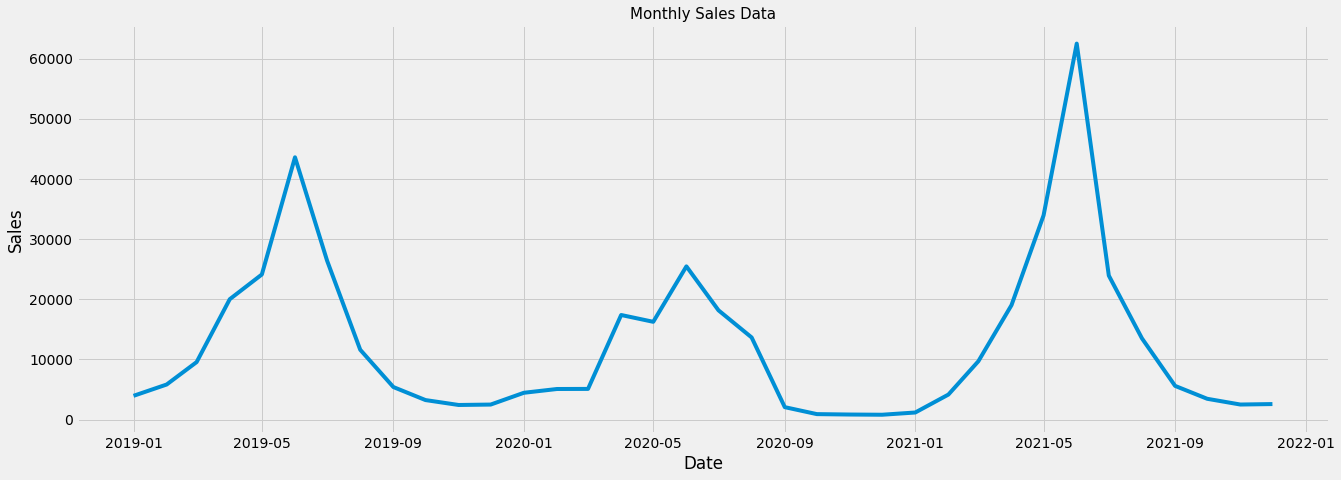

In [5]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("Monthly Sales Data",fontsize=15)
plt.show()

# Exploratory Data Analysis

Creates time series features from Date column.

In [6]:
def date_features(df, label=None):
    df = df.copy()
    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['quarter'] = df['date'].dt.quarter
    X = df[['date','quarter','month','year']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='Sales')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,date,quarter,month,year,Sales
0,2019-01-01,1,January,2019,3936
1,2019-02-01,1,February,2019,5818
2,2019-03-01,1,March,2019,9546
3,2019-04-01,2,April,2019,20003
4,2019-05-01,2,May,2019,24114


## Plotting the Features to see trends
* Sales has strong monthly and seasonal properties.
* 2nd and 3rd quarter/ summer season also seems to show differences in peaks

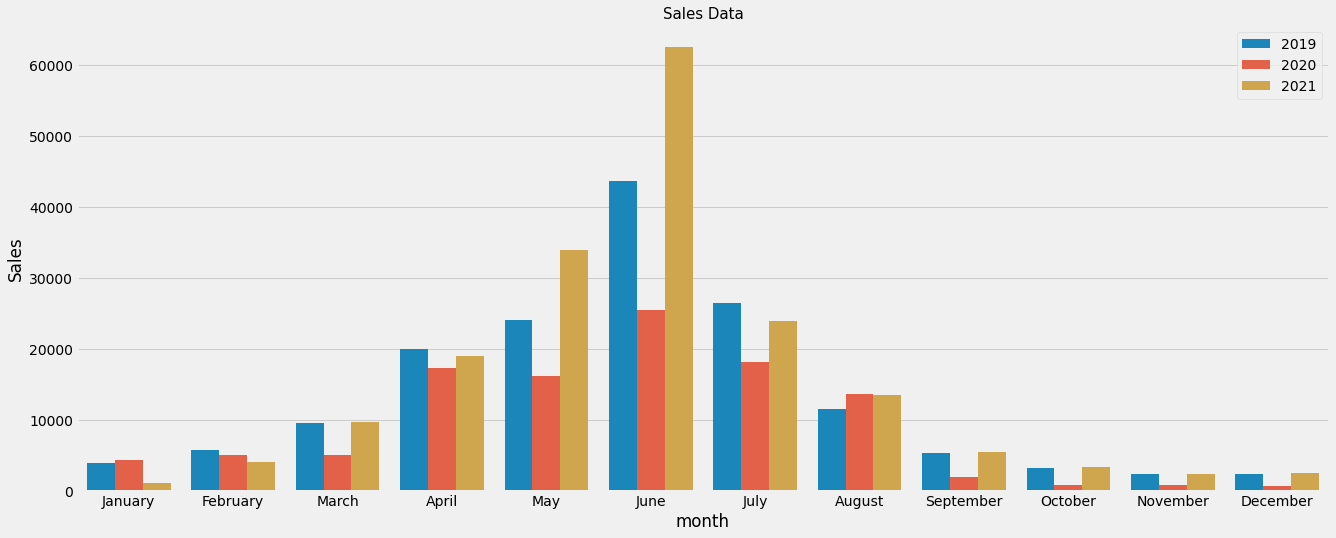

In [7]:
fig, ax = plt.subplots(figsize=(20,8))
palette = sns.color_palette("mako_r", 3)
a = sns.barplot(x="month", y="Sales",hue = 'year',data=df_new)
a.set_title("Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales received By year')

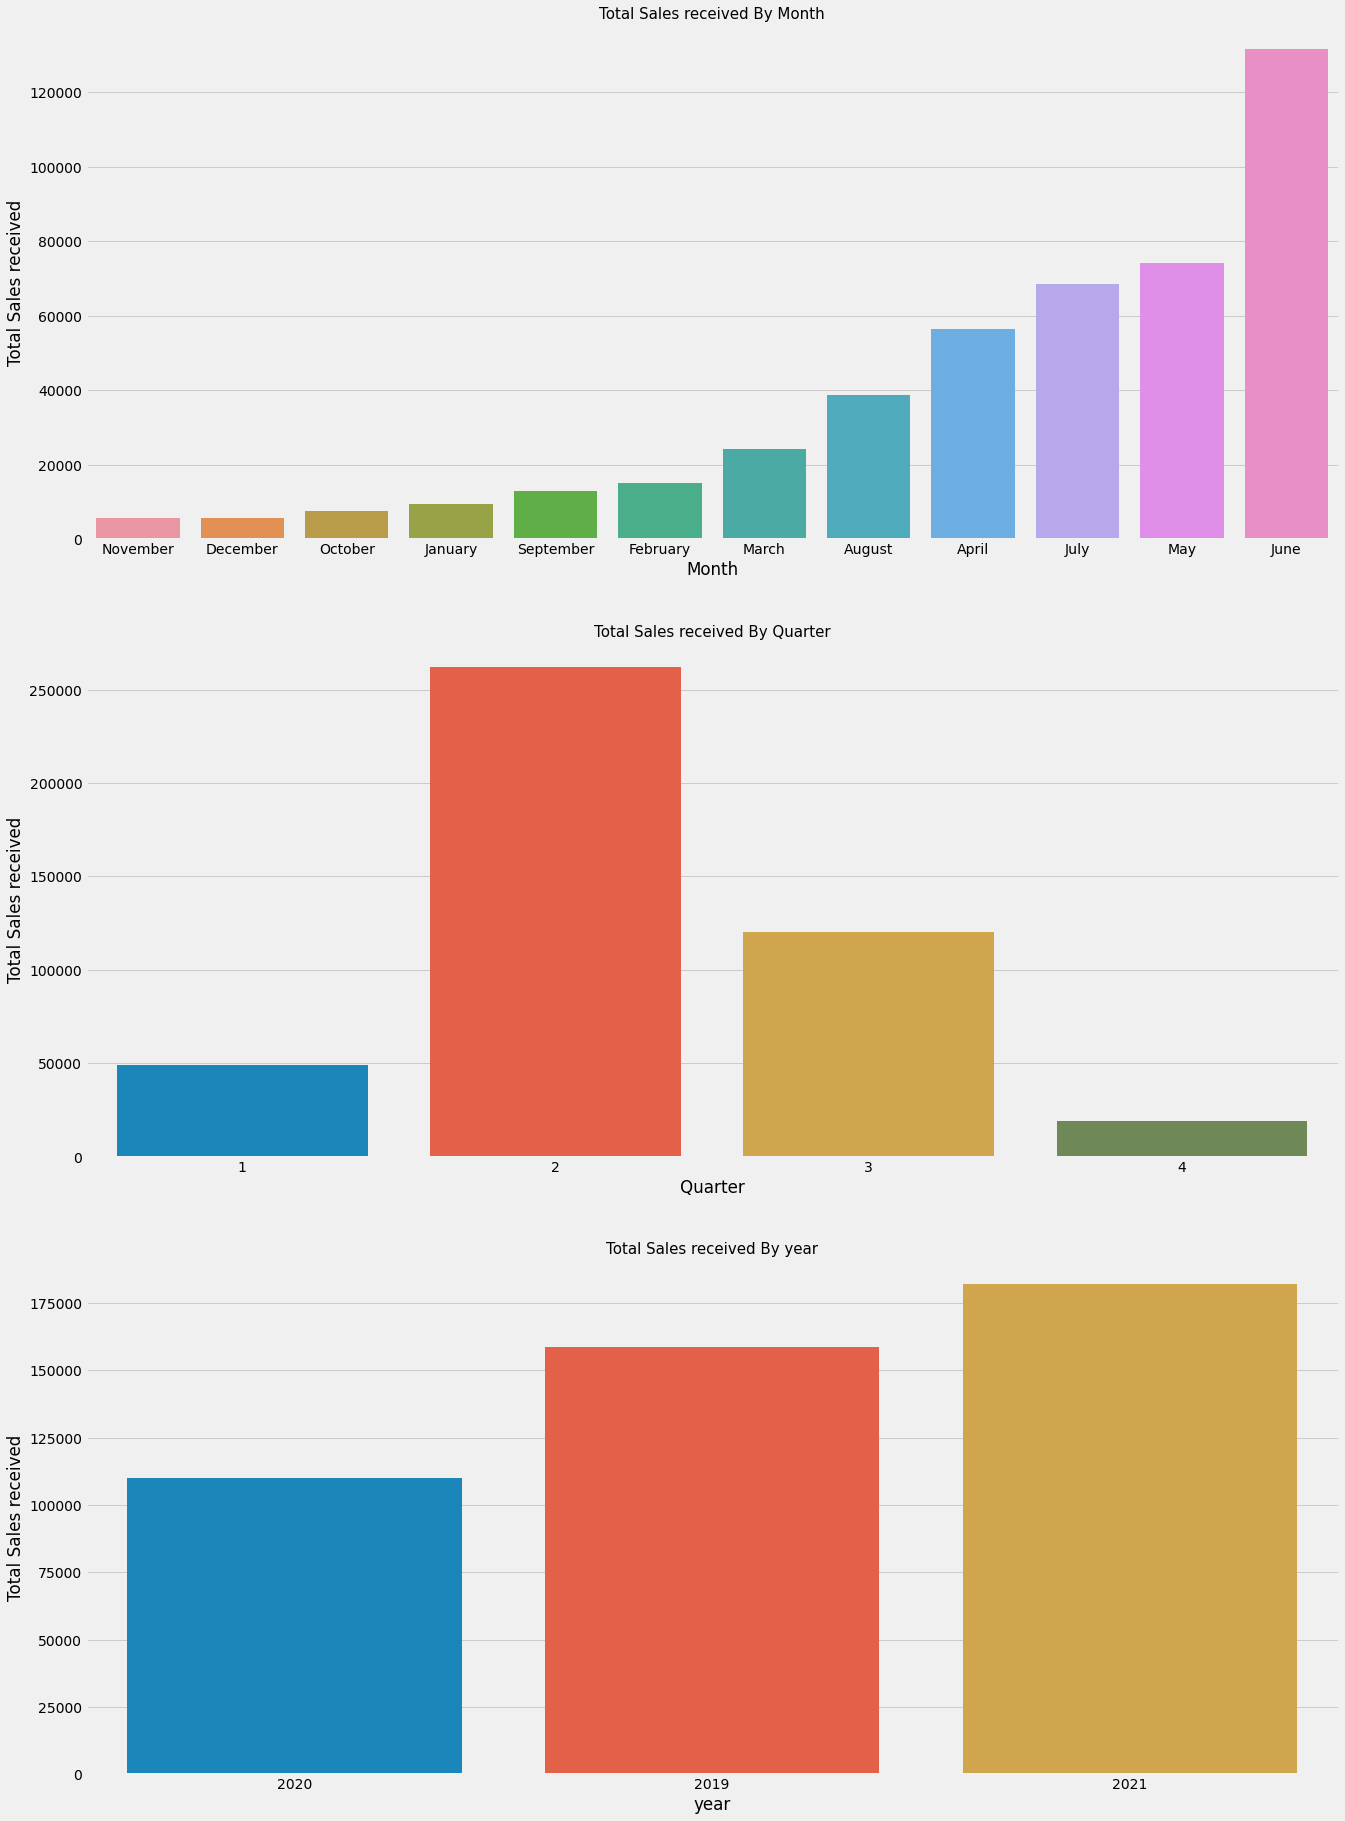

In [8]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="month",y="Sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="quarter",y="Sales",ax=ax2)
ax2.set(xlabel='Quarter', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="year",y="Sales",ax=ax3)
ax3.set(xlabel='year', ylabel='Total Sales received')
ax3.set_title("Total Sales received By year",fontsize=15)

In [9]:
df=df.rename(columns={'Date':'ds','Sales':'y'})
df.head()

,ds,y
0,2019-01-01,3936
1,2019-02-01,5818
2,2019-03-01,9546
3,2019-04-01,20003
4,2019-05-01,24114


Dividing the dataset into train and test. The train has data from Jan,2019 to to Dec,2020. Test Data has 12 months from Jan,2021 to Dec 2021.

In [10]:
end_date = '2020-12-31'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [11]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (24, 2)
test shape (12, 2)


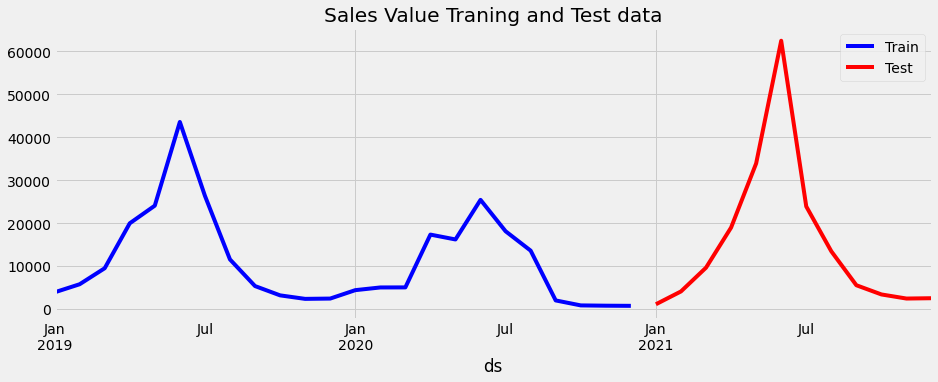

In [12]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Value Traning and Test data')
plt.show()

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Simple Prophet Model

In [14]:
model =Prophet()
model.fit(X_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/afkggpeq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/96ric3sv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10812', 'data', 'file=/tmp/tmppkfqt7e3/afkggpeq.json', 'init=/tmp/tmppkfqt7e3/96ric3sv.json', 'output', 'file=/tmp/tmp2rbopi4_/prophet_model-20220912205959.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:59:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1]

Now, we will predict by creating future dataframe next dates of train data. make_future_dataframe has include_history = True by default. So the predcition will be done for train data as well.

In [15]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,5651.864594,-6990.168781,18833.377850
25,2021-02-01,5203.253720,-7866.647068,18973.892054
26,2021-03-01,4798.056801,-7099.205662,17994.698528
27,2021-04-01,4349.445926,-8850.960468,17597.909794
28,2021-05-01,3915.306370,-8987.945616,16509.057619
29,2021-06-01,3466.695496,-9416.417791,16379.300575
30,2021-07-01,3032.555940,-9296.553349,16258.468652
31,2021-08-01,2583.945065,-10371.033560,16159.636607
32,2021-09-01,2135.334191,-10293.614515,14854.570205
33,2021-10-01,1701.194635,-11535.173123,15557.649623


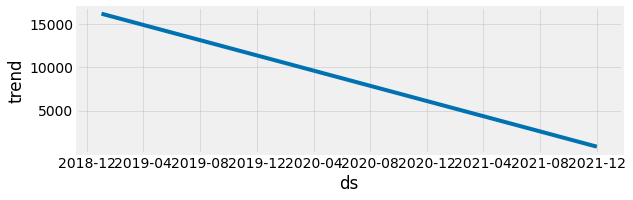

In [16]:
# Plot the components of the model
fig = model.plot_components(forecast)

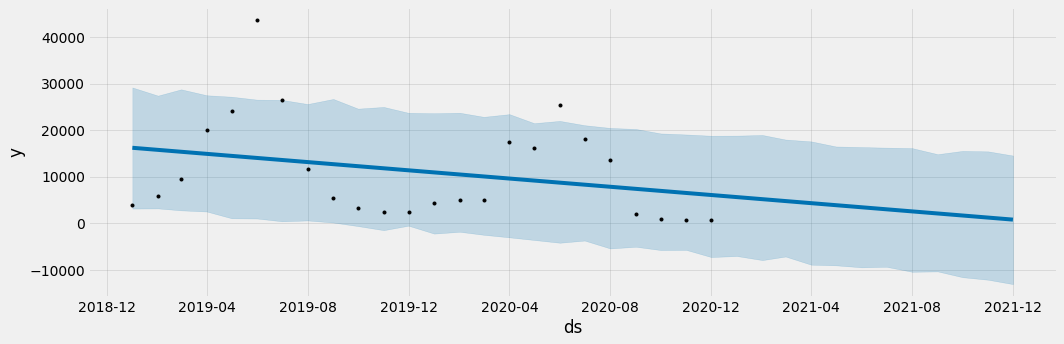

In [17]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

## Actual vs Prediction Comparison

In [18]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
5,2021-06-01,3466.695496,-10144.066090,15164.882244
6,2021-07-01,3032.555940,-10408.046583,15340.676601
7,2021-08-01,2583.945065,-10600.571422,15428.440689
8,2021-09-01,2135.334191,-10654.503117,15447.943999
9,2021-10-01,1701.194635,-11691.360239,14424.180088
10,2021-11-01,1252.583760,-11844.860815,14359.743765
11,2021-12-01,818.444204,-12749.200241,13513.270493


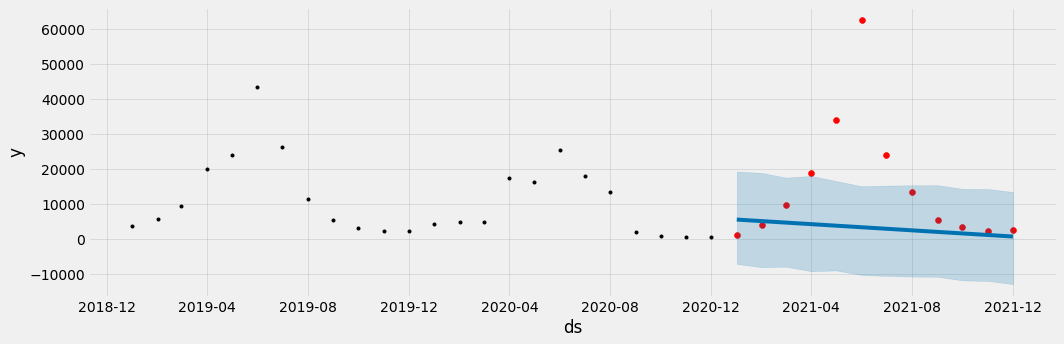

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

### Compare the test Sales and forecasted Sales

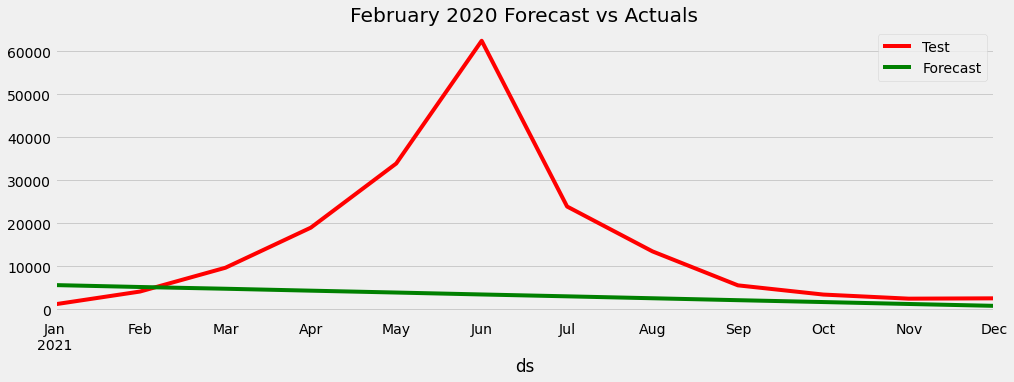

In [20]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.

In [21]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 93.3586


### Adding Holidays to the model
We will use **holidays** library to get the DE holidays

In [22]:
import holidays

In [23]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Germany(years=[2019,2020,2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "de-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [24]:
holiday.head()

,ds,holiday
0,2019-01-01,de-Holidays
1,2019-04-19,de-Holidays
2,2019-04-22,de-Holidays
3,2019-05-01,de-Holidays
4,2019-05-30,de-Holidays


In [25]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/q6i11i5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wc4f5mi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85317', 'data', 'file=/tmp/tmppkfqt7e3/q6i11i5n.json', 'init=/tmp/tmppkfqt7e3/wc4f5mi7.json', 'output', 'file=/tmp/tmp8a67eamu/prophet_model-20220912210013.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:00:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1]

In [26]:
future = model_with_holidays.make_future_dataframe(periods=12, freq='MS')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,9005.783247,-4066.007213,22003.079959
25,2021-02-01,4849.219158,-7429.382143,17290.526968
26,2021-03-01,4471.137206,-8646.628448,17209.291436
27,2021-04-01,4052.546473,-9100.333799,16741.606797
28,2021-05-01,7385.432021,-5006.037981,20370.809817
29,2021-06-01,3228.867933,-10387.658095,15874.024997
30,2021-07-01,2823.780127,-9805.844532,15829.595593
31,2021-08-01,2405.189393,-10252.337248,14442.990339
32,2021-09-01,1986.598660,-11750.357401,14545.882292
33,2021-10-01,1581.510854,-10754.628725,13716.316283


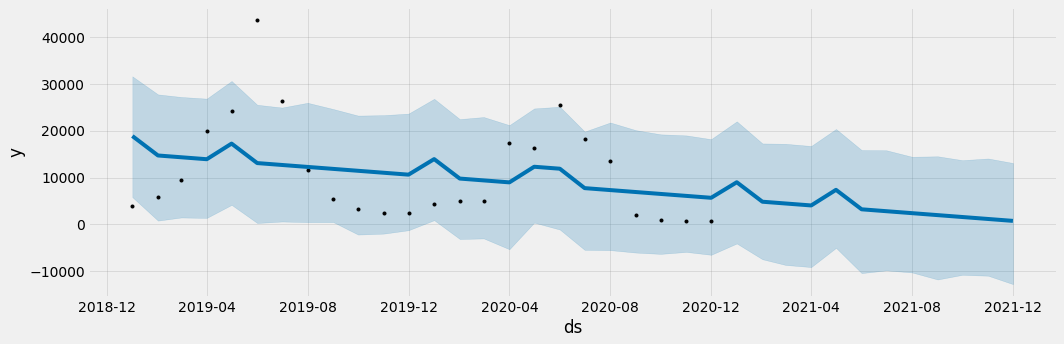

In [27]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

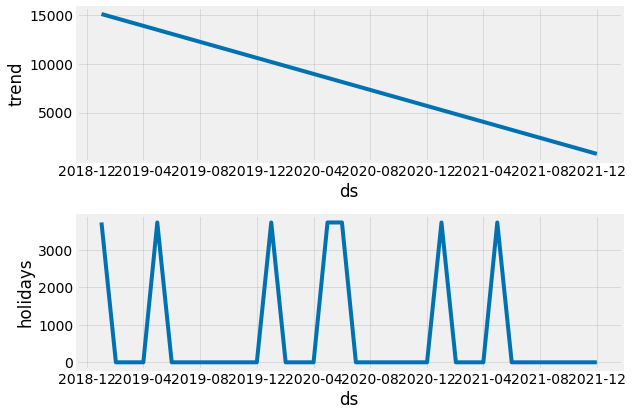

In [28]:
# Plot the components of the model
fig = model_with_holidays.plot_components(forecast)

In [29]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,9005.783247,-3126.142896,21680.300337
1,2021-02-01,4849.219158,-7679.100725,18290.651338
2,2021-03-01,4471.137206,-7562.111993,17313.486619
3,2021-04-01,4052.546473,-9063.826129,18009.149516
4,2021-05-01,7385.432021,-5447.727383,19823.236435
5,2021-06-01,3228.867933,-10448.823615,16208.982529
6,2021-07-01,2823.780127,-9163.187229,15394.485515
7,2021-08-01,2405.189393,-9931.003450,16191.133796
8,2021-09-01,1986.598660,-10491.935961,14822.040194
9,2021-10-01,1581.510854,-11726.330303,13133.700832


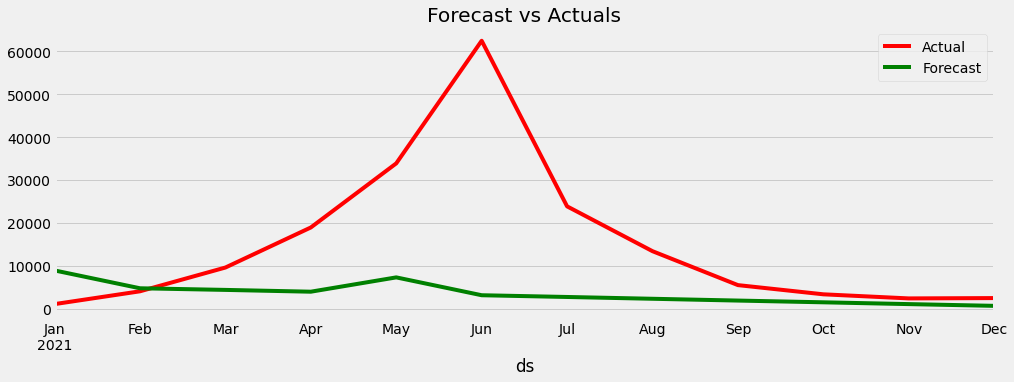

In [30]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [31]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 117.4619


From the above results, we can see that by adding holidays in the model, model performance further reduced. We need to add other parameters to tune the model.

Along with holidays, there are many other hyperparameters which helps in optimizing the prophet model.
1. Holidays
2. Changepoints: (n_changepoints,changepoint_prior_scale)
4. seasonality_mode
5. holiday_prior_scale
6. Seasonalities with fourier_order

We have added holidays to our model and saw its effect. 

**n_changepoints** is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing *n_changepoints* can add value to the model.

**changepoint_prior_scale** to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

**seasonality_mode** There are 2 types model seasonality mode. **Additive & multiplicaticative**. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

**holiday_prior_scale** just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

**Seasonalities with fourier_order** Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.


Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination.
I am taking 4 parameters: n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale for tuning.

# HyperParameter Tuning using ParameterGrid

In [32]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,5],
              'n_changepoints' : [6,12,18,24]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 200


In [33]:
#def is_nfl_season(ds):
#    date = pd.to_datetime(ds)
#    return (date.month > 3 or date.month < 8)

#X_tr['on_season'] = X_tr['ds'].apply(is_nfl_season)
#X_tr['off_season'] = ~X_tr['ds'].apply(is_nfl_season)

def main_season(ds):
    date = pd.to_datetime(ds)
    if date.month > 3 and date.month < 7:
        return 1
    else:
        return 0
X_tr['main_season'] = X_tr['ds'].apply(main_season)

def peak_season(ds):
    date = pd.to_datetime(ds)
    if date.month == 6:
        return 1
    else:
        return 0
X_tr['peak_season'] = X_tr['ds'].apply(peak_season)

In [34]:
X_tr

,ds,y,main_season,peak_season
0,2019-01-01,3936,0,0
1,2019-02-01,5818,0,0
2,2019-03-01,9546,0,0
3,2019-04-01,20003,1,0
4,2019-05-01,24114,1,0
5,2019-06-01,43596,1,1
6,2019-07-01,26415,0,0
7,2019-08-01,11597,0,0
8,2019-09-01,5396,0,0
9,2019-10-01,3232,0,0


# Prophet Model Tuning

In [35]:
strt='2020-12-01'
end='2021-12-01'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         #weekly_seasonality=True,
                         #daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='DE')
 
    #train_model.add_seasonality(name='weekly_on_season', period=30.5, fourier_order=3, condition_name='on_season')
    #train_model.add_seasonality(name='weekly_off_season', period=30.5, fourier_order=3, condition_name='off_season')
    train_model.add_regressor('main_season')
    train_model.add_regressor('peak_season')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=12, freq='MS',include_history = False)
    #train_forecast['on_season'] = train_forecast['ds'].apply(is_nfl_season)
    #train_forecast['off_season'] = ~train_forecast['ds'].apply(is_nfl_season) 

    train_forecast['main_season'] = train_forecast['ds'].apply(main_season)
    train_forecast['peak_season'] = train_forecast['ds'].apply(peak_season)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/iiqoe3gt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/uer4vyft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21217', 'data', 'file=/tmp/tmppkfqt7e3/iiqoe3gt.json', 'init=/tmp/tmppkfqt7e3/uer4vyft.json', 'output', 'file=/tmp/tmpneirzh3y/prophet_model-20220912210028.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:00:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with we

Mean Absolute Percentage Error(MAPE)------------------------------------ 77.71337557764922
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qhz58xhe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1d9_av9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22355', 'data', 'file=/tmp/tmppkfqt7e3/qhz58xhe.json', 'init=/tmp/tmppkfqt7e3/1d9_av9_.json', 'output', 'file=/tmp/tmplgt03lzf/prophet_model-20220912210058.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:00:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 80.73274043006869
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:01:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/t64j_7rr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/0ewpg16a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85540', 'data', 'file=/tmp/tmppkfqt7e3/t64j_7rr.json', 'init=/tmp/tmppkfqt7e3/0ewpg16a.json', 'output', 'file=/tmp/tmp53moe5cf/prophet_model-20220912210118.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:01:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.09020404482219
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:01:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/p5_q8kdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/dkvlr2_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58204', 'data', 'file=/tmp/tmppkfqt7e3/p5_q8kdd.json', 'init=/tmp/tmppkfqt7e3/dkvlr2_i.json', 'output', 'file=/tmp/tmpyt4ek1r3/prophet_model-20220912210138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:01:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 85.4377958503357
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:02:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/s08zsiw3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/szy01fkr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37541', 'data', 'file=/tmp/tmppkfqt7e3/s08zsiw3.json', 'init=/tmp/tmppkfqt7e3/szy01fkr.json', 'output', 'file=/tmp/tmp0eaq_dsr/prophet_model-20220912210203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 75.62288141122768
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wo2a86it.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/z6k4mrxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14031', 'data', 'file=/tmp/tmppkfqt7e3/wo2a86it.json', 'init=/tmp/tmppkfqt7e3/z6k4mrxu.json', 'output', 'file=/tmp/tmp7ivgmj3s/prophet_model-20220912210229.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 82.26303169476896
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/tbpmz_xr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4iw7obbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10626', 'data', 'file=/tmp/tmppkfqt7e3/tbpmz_xr.json', 'init=/tmp/tmppkfqt7e3/4iw7obbk.json', 'output', 'file=/tmp/tmpglstuyk6/prophet_model-20220912210254.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 75.62288141122768
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:03:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/b_utv51c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_hn108vl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42877', 'data', 'file=/tmp/tmppkfqt7e3/b_utv51c.json', 'init=/tmp/tmppkfqt7e3/_hn108vl.json', 'output', 'file=/tmp/tmp_xp4jq50/prophet_model-20220912210320.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:03:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 82.26303169476896
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:03:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/dqqbgb1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4ahinms5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87514', 'data', 'file=/tmp/tmppkfqt7e3/dqqbgb1j.json', 'init=/tmp/tmppkfqt7e3/4ahinms5.json', 'output', 'file=/tmp/tmpa6cme2m0/prophet_model-20220912210337.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.25628219881928
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:03:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/5yhicnrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/isqy8pev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9257', 'data', 'file=/tmp/tmppkfqt7e3/5yhicnrq.json', 'init=/tmp/tmppkfqt7e3/isqy8pev.json', 'output', 'file=/tmp/tmpqrh8n1yf/prophet_model-20220912210354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 93.46012682997058
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:04:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/sonjq3q5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/9e_2_1i_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9750', 'data', 'file=/tmp/tmppkfqt7e3/sonjq3q5.json', 'init=/tmp/tmppkfqt7e3/9e_2_1i_.json', 'output', 'file=/tmp/tmpuik1og9v/prophet_model-20220912210414.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:04:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 76.10145938266123
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:04:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4_rizakq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/v9e5f89q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3436', 'data', 'file=/tmp/tmppkfqt7e3/4_rizakq.json', 'init=/tmp/tmppkfqt7e3/v9e5f89q.json', 'output', 'file=/tmp/tmplcpu9oi6/prophet_model-20220912210435.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:04:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 91.57564489494266
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:04:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/b1iur3gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ad07ug7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57066', 'data', 'file=/tmp/tmppkfqt7e3/b1iur3gn.json', 'init=/tmp/tmppkfqt7e3/ad07ug7z.json', 'output', 'file=/tmp/tmp9rdicuw4/prophet_model-20220912210500.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 88.09173559480172
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:05:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/nf1i79bo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/urmov315.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29380', 'data', 'file=/tmp/tmppkfqt7e3/nf1i79bo.json', 'init=/tmp/tmppkfqt7e3/urmov315.json', 'output', 'file=/tmp/tmpsgbqm8no/prophet_model-20220912210524.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:05:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 83.38262219858402
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:05:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/39_l46q4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lhs5wjqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31651', 'data', 'file=/tmp/tmppkfqt7e3/39_l46q4.json', 'init=/tmp/tmppkfqt7e3/lhs5wjqw.json', 'output', 'file=/tmp/tmpyeokneuo/prophet_model-20220912210550.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:05:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 88.09173559480172
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:06:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/oo_vzvtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cy5q8h1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74656', 'data', 'file=/tmp/tmppkfqt7e3/oo_vzvtz.json', 'init=/tmp/tmppkfqt7e3/cy5q8h1k.json', 'output', 'file=/tmp/tmp91fpw5c0/prophet_model-20220912210619.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:06:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 83.38262219858402
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:06:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/r19xz840.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/9ewobwlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13424', 'data', 'file=/tmp/tmppkfqt7e3/r19xz840.json', 'init=/tmp/tmppkfqt7e3/9ewobwlz.json', 'output', 'file=/tmp/tmpjd3mt871/prophet_model-20220912210636.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:06:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 83.02680933515929
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:07:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ucgbnzr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1h23r8r7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68762', 'data', 'file=/tmp/tmppkfqt7e3/ucgbnzr8.json', 'init=/tmp/tmppkfqt7e3/1h23r8r7.json', 'output', 'file=/tmp/tmpb1f70rnb/prophet_model-20220912210702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 77.58245471703576
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:07:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/fh21fkuu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/oi2hxfw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14971', 'data', 'file=/tmp/tmppkfqt7e3/fh21fkuu.json', 'init=/tmp/tmppkfqt7e3/oi2hxfw1.json', 'output', 'file=/tmp/tmpmsoxu3mx/prophet_model-20220912210722.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:07:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.32183153307797
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:07:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/unls7wgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/aiqbaprm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56366', 'data', 'file=/tmp/tmppkfqt7e3/unls7wgu.json', 'init=/tmp/tmppkfqt7e3/aiqbaprm.json', 'output', 'file=/tmp/tmpmgbzcva6/prophet_model-20220912210742.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 90.44726560428194
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:08:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/zie5he75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cu_8hz4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37937', 'data', 'file=/tmp/tmppkfqt7e3/zie5he75.json', 'init=/tmp/tmppkfqt7e3/cu_8hz4a.json', 'output', 'file=/tmp/tmpubq0jiwc/prophet_model-20220912210807.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:08:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 77.24131231708736
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:08:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/edc7pm6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7pghc87u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42054', 'data', 'file=/tmp/tmppkfqt7e3/edc7pm6f.json', 'init=/tmp/tmppkfqt7e3/7pghc87u.json', 'output', 'file=/tmp/tmps72wdwam/prophet_model-20220912210835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:08:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 117.53232020243416
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:08:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/y4m88_jc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rtpgql8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55797', 'data', 'file=/tmp/tmppkfqt7e3/y4m88_jc.json', 'init=/tmp/tmppkfqt7e3/rtpgql8m.json', 'output', 'file=/tmp/tmp41yox727/prophet_model-20220912210900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:09:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 77.24131231708736
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:09:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/skcs5slj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/bv33hr6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94936', 'data', 'file=/tmp/tmppkfqt7e3/skcs5slj.json', 'init=/tmp/tmppkfqt7e3/bv33hr6t.json', 'output', 'file=/tmp/tmpzzxrfv0s/prophet_model-20220912210924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 117.53232020243416
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:09:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/8a0ixgmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1jm6azt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17952', 'data', 'file=/tmp/tmppkfqt7e3/8a0ixgmj.json', 'init=/tmp/tmppkfqt7e3/1jm6azt5.json', 'output', 'file=/tmp/tmp6xlg_8_u/prophet_model-20220912210942.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:09:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 72.06069991378192
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/pt4v9seb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/hoosu2ua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65793', 'data', 'file=/tmp/tmppkfqt7e3/pt4v9seb.json', 'init=/tmp/tmppkfqt7e3/hoosu2ua.json', 'output', 'file=/tmp/tmp1mv2awjw/prophet_model-20220912210959.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 80.6323317542009
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:10:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2n9vnhbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ocac_bk3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13229', 'data', 'file=/tmp/tmppkfqt7e3/2n9vnhbr.json', 'init=/tmp/tmppkfqt7e3/ocac_bk3.json', 'output', 'file=/tmp/tmpc9d7h6qi/prophet_model-20220912211019.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 77.48556736037516
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:10:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/l63lw038.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/je9zi9z3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47014', 'data', 'file=/tmp/tmppkfqt7e3/l63lw038.json', 'init=/tmp/tmppkfqt7e3/je9zi9z3.json', 'output', 'file=/tmp/tmp9qjb0hn5/prophet_model-20220912211040.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 97.15802631938922
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:11:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ncdn0lrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/byqsv9b_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83463', 'data', 'file=/tmp/tmppkfqt7e3/ncdn0lrb.json', 'init=/tmp/tmppkfqt7e3/byqsv9b_.json', 'output', 'file=/tmp/tmp2dnpjt1w/prophet_model-20220912211106.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:11:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 74.41563639306528
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:11:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/8y2rx80h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4uniaybb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78410', 'data', 'file=/tmp/tmppkfqt7e3/8y2rx80h.json', 'init=/tmp/tmppkfqt7e3/4uniaybb.json', 'output', 'file=/tmp/tmp33c1h_89/prophet_model-20220912211130.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:11:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 90.85259516043286
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:11:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/93zum42_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/trwlmw77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87943', 'data', 'file=/tmp/tmppkfqt7e3/93zum42_.json', 'init=/tmp/tmppkfqt7e3/trwlmw77.json', 'output', 'file=/tmp/tmpivyobyj_/prophet_model-20220912211156.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.41563639306528
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:12:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/payeqtxq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/xz4chqg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99476', 'data', 'file=/tmp/tmppkfqt7e3/payeqtxq.json', 'init=/tmp/tmppkfqt7e3/xz4chqg5.json', 'output', 'file=/tmp/tmpxsglnev5/prophet_model-20220912211220.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:12:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 90.85259516043286
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/a_gf7v27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/0xhdnl5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30070', 'data', 'file=/tmp/tmppkfqt7e3/a_gf7v27.json', 'init=/tmp/tmppkfqt7e3/0xhdnl5t.json', 'output', 'file=/tmp/tmpmx7uc81v/prophet_model-20220912211237.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 82.42532727530792
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/oi81fxpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/pb73druc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97897', 'data', 'file=/tmp/tmppkfqt7e3/oi81fxpt.json', 'init=/tmp/tmppkfqt7e3/pb73druc.json', 'output', 'file=/tmp/tmpwjsvkkis/prophet_model-20220912211253.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 78.30605009938255
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:13:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/a_8y11cq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/pzsbumwm.json
DEBUG:cmdstanpy:idx 0


Mean Absolute Percentage Error(MAPE)------------------------------------ 85.95109478270317
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41887', 'data', 'file=/tmp/tmppkfqt7e3/a_8y11cq.json', 'init=/tmp/tmppkfqt7e3/pzsbumwm.json', 'output', 'file=/tmp/tmp6ckzmrec/prophet_model-20220912211314.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/h5lrwy6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/75j72kfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdst

Mean Absolute Percentage Error(MAPE)------------------------------------ 80.56914196861258
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:13:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/w0qay5fw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7100mdt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62742', 'data', 'file=/tmp/tmppkfqt7e3/w0qay5fw.json', 'init=/tmp/tmppkfqt7e3/7100mdt9.json', 'output', 'file=/tmp/tmpruqe4z0x/prophet_model-20220912211400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:14:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 63.78606998909504
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/msyc7bvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/zn96kuro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92549', 'data', 'file=/tmp/tmppkfqt7e3/msyc7bvm.json', 'init=/tmp/tmppkfqt7e3/zn96kuro.json', 'output', 'file=/tmp/tmpgjdnzuuv/prophet_model-20220912211424.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:14:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 79.85825627044811
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/m_x71_rm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/aeck_tra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1774', 'data', 'file=/tmp/tmppkfqt7e3/m_x71_rm.json', 'init=/tmp/tmppkfqt7e3/aeck_tra.json', 'output', 'file=/tmp/tmpzp0o4odg/prophet_model-20220912211450.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:14:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start

Mean Absolute Percentage Error(MAPE)------------------------------------ 63.78606998909504
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:15:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/dh2zh49a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/p0vpx6ni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56736', 'data', 'file=/tmp/tmppkfqt7e3/dh2zh49a.json', 'init=/tmp/tmppkfqt7e3/p0vpx6ni.json', 'output', 'file=/tmp/tmpxt_jl01e/prophet_model-20220912211514.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.85825627044811
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:15:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7uixljzh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/j65bo9c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4743', 'data', 'file=/tmp/tmppkfqt7e3/7uixljzh.json', 'init=/tmp/tmppkfqt7e3/j65bo9c5.json', 'output', 'file=/tmp/tmpc_n73b9f/prophet_model-20220912211531.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:15:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 68.67962362839032
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2cbmslav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2ia7p9z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77865', 'data', 'file=/tmp/tmppkfqt7e3/2cbmslav.json', 'init=/tmp/tmppkfqt7e3/2ia7p9z2.json', 'output', 'file=/tmp/tmpeq1xed3d/prophet_model-20220912211548.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:15:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.33584449938367
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:16:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/emr4i6iv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rea62vlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2693', 'data', 'file=/tmp/tmppkfqt7e3/emr4i6iv.json', 'init=/tmp/tmppkfqt7e3/rea62vlt.json', 'output', 'file=/tmp/tmpuqkxw1jl/prophet_model-20220912211609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 90.23381664210132
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:16:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/3xfslsv_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1fx9qzn8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40063', 'data', 'file=/tmp/tmppkfqt7e3/3xfslsv_.json', 'init=/tmp/tmppkfqt7e3/1fx9qzn8.json', 'output', 'file=/tmp/tmp1_qsbpl5/prophet_model-20220912211629.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.47549831806255
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:16:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mejyg5zy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7mtrzzpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51742', 'data', 'file=/tmp/tmppkfqt7e3/mejyg5zy.json', 'init=/tmp/tmppkfqt7e3/7mtrzzpf.json', 'output', 'file=/tmp/tmpgecgw0qi/prophet_model-20220912211653.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.58494220113784
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:17:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6ji7f0yy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/iwi1lio5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=111', 'data', 'file=/tmp/tmppkfqt7e3/6ji7f0yy.json', 'init=/tmp/tmppkfqt7e3/iwi1lio5.json', 'output', 'file=/tmp/tmpwaw8hi1z/prophet_model-20220912211718.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:17:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start 

Mean Absolute Percentage Error(MAPE)------------------------------------ 115.93756679234752
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:17:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ilzkx38t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/h7d44rog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60976', 'data', 'file=/tmp/tmppkfqt7e3/ilzkx38t.json', 'init=/tmp/tmppkfqt7e3/h7d44rog.json', 'output', 'file=/tmp/tmpacrh6k1r/prophet_model-20220912211743.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 70.58494220113784
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:18:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qf27t_pw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/8bmb58op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44395', 'data', 'file=/tmp/tmppkfqt7e3/qf27t_pw.json', 'init=/tmp/tmppkfqt7e3/8bmb58op.json', 'output', 'file=/tmp/tmpj0d15h55/prophet_model-20220912211807.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 115.93756679234752
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/94xelyx_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lhvd998z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59386', 'data', 'file=/tmp/tmppkfqt7e3/94xelyx_.json', 'init=/tmp/tmppkfqt7e3/lhvd998z.json', 'output', 'file=/tmp/tmp5ajuaxym/prophet_model-20220912211826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 68.3571477066157
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ttytcbxq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/5ml7vko6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78941', 'data', 'file=/tmp/tmppkfqt7e3/ttytcbxq.json', 'init=/tmp/tmppkfqt7e3/5ml7vko6.json', 'output', 'file=/tmp/tmp8c6zkgxf/prophet_model-20220912211843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.51781322698264
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/iemfsgmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rklcgo0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80541', 'data', 'file=/tmp/tmppkfqt7e3/iemfsgmd.json', 'init=/tmp/tmppkfqt7e3/rklcgo0k.json', 'output', 'file=/tmp/tmpv8ztkgw_/prophet_model-20220912211904.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.12446759205652
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/07faxfdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/14gpuqa8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43320', 'data', 'file=/tmp/tmppkfqt7e3/07faxfdc.json', 'init=/tmp/tmppkfqt7e3/14gpuqa8.json', 'output', 'file=/tmp/tmp6k0amtpo/prophet_model-20220912211924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 92.70439704281287
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:19:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lkrugmpc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/006f_eel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4266', 'data', 'file=/tmp/tmppkfqt7e3/lkrugmpc.json', 'init=/tmp/tmppkfqt7e3/006f_eel.json', 'output', 'file=/tmp/tmpwv3t1hx3/prophet_model-20220912211949.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 71.92174265178176
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1tso8wy9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2yy8efid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36880', 'data', 'file=/tmp/tmppkfqt7e3/1tso8wy9.json', 'init=/tmp/tmppkfqt7e3/2yy8efid.json', 'output', 'file=/tmp/tmpqhve79ry/prophet_model-20220912212014.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 102.63739989718843
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/m9r61xdr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/3gtelj1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29306', 'data', 'file=/tmp/tmppkfqt7e3/m9r61xdr.json', 'init=/tmp/tmppkfqt7e3/3gtelj1u.json', 'output', 'file=/tmp/tmpj4_e8bdg/prophet_model-20220912212039.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 71.92174265178176
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qgl839cd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/polluy5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20437', 'data', 'file=/tmp/tmppkfqt7e3/qgl839cd.json', 'init=/tmp/tmppkfqt7e3/polluy5h.json', 'output', 'file=/tmp/tmpd60cw1ih/prophet_model-20220912212105.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.63739989718843
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/vev2tfqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/drf_3m_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69303', 'data', 'file=/tmp/tmppkfqt7e3/vev2tfqe.json', 'init=/tmp/tmppkfqt7e3/drf_3m_h.json', 'output', 'file=/tmp/tmpg2aoa1ls/prophet_model-20220912212122.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.55718726602568
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/brc029fc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2gsofop2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40434', 'data', 'file=/tmp/tmppkfqt7e3/brc029fc.json', 'init=/tmp/tmppkfqt7e3/2gsofop2.json', 'output', 'file=/tmp/tmp4kadvczm/prophet_model-20220912212140.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 95.56707915116885
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/xlmxu3pv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wjq2yz7w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76000', 'data', 'file=/tmp/tmppkfqt7e3/xlmxu3pv.json', 'init=/tmp/tmppkfqt7e3/wjq2yz7w.json', 'output', 'file=/tmp/tmpcouhh0_6/prophet_model-20220912212200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.92282577961265
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qra188qo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mdi_4_1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25946', 'data', 'file=/tmp/tmppkfqt7e3/qra188qo.json', 'init=/tmp/tmppkfqt7e3/mdi_4_1y.json', 'output', 'file=/tmp/tmpg3949wt5/prophet_model-20220912212221.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 76.60019895401095
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/owgu6vu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/gj4ofd54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3882', 'data', 'file=/tmp/tmppkfqt7e3/owgu6vu0.json', 'init=/tmp/tmppkfqt7e3/gj4ofd54.json', 'output', 'file=/tmp/tmp3cipf6h6/prophet_model-20220912212246.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 75.70816245257438
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/y2q5wi8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/yb8ph9j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68222', 'data', 'file=/tmp/tmppkfqt7e3/y2q5wi8h.json', 'init=/tmp/tmppkfqt7e3/yb8ph9j0.json', 'output', 'file=/tmp/tmpqviw92qb/prophet_model-20220912212310.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 89.04356695448773
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/quva684z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ocyshfst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87747', 'data', 'file=/tmp/tmppkfqt7e3/quva684z.json', 'init=/tmp/tmppkfqt7e3/ocyshfst.json', 'output', 'file=/tmp/tmp_kq4eqxe/prophet_model-20220912212337.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 75.70816245257438
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:23:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/t6o70fnl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/uhfmo8ge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22967', 'data', 'file=/tmp/tmppkfqt7e3/t6o70fnl.json', 'init=/tmp/tmppkfqt7e3/uhfmo8ge.json', 'output', 'file=/tmp/tmpl3lsd8l7/prophet_model-20220912212401.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 89.04356695448773
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/71xnhq0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/spp5zq2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24014', 'data', 'file=/tmp/tmppkfqt7e3/71xnhq0y.json', 'init=/tmp/tmppkfqt7e3/spp5zq2o.json', 'output', 'file=/tmp/tmpwt3gc5ym/prophet_model-20220912212418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 66.74329023615464
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/oue7oukf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/enz3l3lm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61083', 'data', 'file=/tmp/tmppkfqt7e3/oue7oukf.json', 'init=/tmp/tmppkfqt7e3/enz3l3lm.json', 'output', 'file=/tmp/tmpztwbp0pi/prophet_model-20220912212435.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 89.12594842724802
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/8lkbkf3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/5ucqh65p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95992', 'data', 'file=/tmp/tmppkfqt7e3/8lkbkf3z.json', 'init=/tmp/tmppkfqt7e3/5ucqh65p.json', 'output', 'file=/tmp/tmp9jhtb_ts/prophet_model-20220912212456.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 69.11890451022163
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cs2pn5hx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_5vghwth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61973', 'data', 'file=/tmp/tmppkfqt7e3/cs2pn5hx.json', 'init=/tmp/tmppkfqt7e3/_5vghwth.json', 'output', 'file=/tmp/tmpgbvl59o0/prophet_model-20220912212516.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 72.77458053525288
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:25:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/30_h__ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/nul_w6px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34964', 'data', 'file=/tmp/tmppkfqt7e3/30_h__ro.json', 'init=/tmp/tmppkfqt7e3/nul_w6px.json', 'output', 'file=/tmp/tmps44bj48y/prophet_model-20220912212541.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 71.13148579495862
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:26:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/b0x69pni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/9cyl6gpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73330', 'data', 'file=/tmp/tmppkfqt7e3/b0x69pni.json', 'init=/tmp/tmppkfqt7e3/9cyl6gpf.json', 'output', 'file=/tmp/tmps_2gb8n2/prophet_model-20220912212607.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 56.48753585921148
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:26:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7ujtzi3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/r0yc5709.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35750', 'data', 'file=/tmp/tmppkfqt7e3/7ujtzi3p.json', 'init=/tmp/tmppkfqt7e3/r0yc5709.json', 'output', 'file=/tmp/tmpape49z1w/prophet_model-20220912212631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 71.13148579495862
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mlgztbrw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mqcnrb6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68528', 'data', 'file=/tmp/tmppkfqt7e3/mlgztbrw.json', 'init=/tmp/tmppkfqt7e3/mqcnrb6o.json', 'output', 'file=/tmp/tmpz_hqp7h0/prophet_model-20220912212655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 56.48753585921148
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:27:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/nr2etzsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/3yxzs5pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39852', 'data', 'file=/tmp/tmppkfqt7e3/nr2etzsr.json', 'init=/tmp/tmppkfqt7e3/3yxzs5pq.json', 'output', 'file=/tmp/tmpw40diurm/prophet_model-20220912212713.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:27:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 114.12885484135205
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:27:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ta1f1n_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/q5x3l5e7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15943', 'data', 'file=/tmp/tmppkfqt7e3/ta1f1n_o.json', 'init=/tmp/tmppkfqt7e3/q5x3l5e7.json', 'output', 'file=/tmp/tmpzyj3531l/prophet_model-20220912212730.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:27:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 229.92270641820744
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_d8mqx26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/x6a2l6cm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89853', 'data', 'file=/tmp/tmppkfqt7e3/_d8mqx26.json', 'init=/tmp/tmppkfqt7e3/x6a2l6cm.json', 'output', 'file=/tmp/tmp_0op028h/prophet_model-20220912212750.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:27:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 85.19018475924415
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/f78s4mf1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/kuuvf216.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83837', 'data', 'file=/tmp/tmppkfqt7e3/f78s4mf1.json', 'init=/tmp/tmppkfqt7e3/kuuvf216.json', 'output', 'file=/tmp/tmpvwnqqdtz/prophet_model-20220912212810.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 77.94411286884103
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_2f47vo7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/c9e42jp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17939', 'data', 'file=/tmp/tmppkfqt7e3/_2f47vo7.json', 'init=/tmp/tmppkfqt7e3/c9e42jp5.json', 'output', 'file=/tmp/tmp6rvajq5q/prophet_model-20220912212826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:28:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 74.15365847859564
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:28:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/tm1xlu9l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/9el0vh7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39427', 'data', 'file=/tmp/tmppkfqt7e3/tm1xlu9l.json', 'init=/tmp/tmppkfqt7e3/9el0vh7r.json', 'output', 'file=/tmp/tmpk3pv4750/prophet_model-20220912212850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 144.43848511956946
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:29:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4tma7k4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/h7z1zc3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66738', 'data', 'file=/tmp/tmppkfqt7e3/4tma7k4q.json', 'init=/tmp/tmppkfqt7e3/h7z1zc3g.json', 'output', 'file=/tmp/tmpl6u60cjq/prophet_model-20220912212904.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 74.15365847859564
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/seyjztz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/s0b_mjpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17289', 'data', 'file=/tmp/tmppkfqt7e3/seyjztz1.json', 'init=/tmp/tmppkfqt7e3/s0b_mjpp.json', 'output', 'file=/tmp/tmpzufc05w3/prophet_model-20220912212928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:29:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 144.43848511956946
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:29:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/sleyw0f4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6chx5z5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62558', 'data', 'file=/tmp/tmppkfqt7e3/sleyw0f4.json', 'init=/tmp/tmppkfqt7e3/6chx5z5g.json', 'output', 'file=/tmp/tmprpgsmznx/prophet_model-20220912212945.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:29:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 75.69157833527966
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/s3kz9or3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mlgstg80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23542', 'data', 'file=/tmp/tmppkfqt7e3/s3kz9or3.json', 'init=/tmp/tmppkfqt7e3/mlgstg80.json', 'output', 'file=/tmp/tmpmt61b92m/prophet_model-20220912213001.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:30:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 116.11881516195066
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:30:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/tg01a8dw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1iemrd85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29806', 'data', 'file=/tmp/tmppkfqt7e3/tg01a8dw.json', 'init=/tmp/tmppkfqt7e3/1iemrd85.json', 'output', 'file=/tmp/tmpcnty5xkw/prophet_model-20220912213022.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:30:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 71.07492134705188
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/o_nsoxe9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wl5s1kh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97001', 'data', 'file=/tmp/tmppkfqt7e3/o_nsoxe9.json', 'init=/tmp/tmppkfqt7e3/wl5s1kh8.json', 'output', 'file=/tmp/tmp4029m5jf/prophet_model-20220912213042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 168.234105376104
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1j9grgeh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1t0bi0r6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41173', 'data', 'file=/tmp/tmppkfqt7e3/1j9grgeh.json', 'init=/tmp/tmppkfqt7e3/1t0bi0r6.json', 'output', 'file=/tmp/tmpaj5k_6k_/prophet_model-20220912213108.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 68.16501817222832
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/fydxrvd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7dushh69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23643', 'data', 'file=/tmp/tmppkfqt7e3/fydxrvd5.json', 'init=/tmp/tmppkfqt7e3/7dushh69.json', 'output', 'file=/tmp/tmpwd1v11p7/prophet_model-20220912213132.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 464.8827242559057
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/o6wgsliq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/80c3vn7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95490', 'data', 'file=/tmp/tmppkfqt7e3/o6wgsliq.json', 'init=/tmp/tmppkfqt7e3/80c3vn7i.json', 'output', 'file=/tmp/tmp6iwnc99l/prophet_model-20220912213157.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:31:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 68.16501817222832
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:32:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/sal7wapy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/j5uuvaoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85751', 'data', 'file=/tmp/tmppkfqt7e3/sal7wapy.json', 'init=/tmp/tmppkfqt7e3/j5uuvaoy.json', 'output', 'file=/tmp/tmpfiac2pjy/prophet_model-20220912213221.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 464.8827242559057
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:32:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/xvm2_6yz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qu7fwkg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52056', 'data', 'file=/tmp/tmppkfqt7e3/xvm2_6yz.json', 'init=/tmp/tmppkfqt7e3/qu7fwkg5.json', 'output', 'file=/tmp/tmpqqzghuiu/prophet_model-20220912213238.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:32:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.68428021293838
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6em1jssf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/kqs3lg87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48290', 'data', 'file=/tmp/tmppkfqt7e3/6em1jssf.json', 'init=/tmp/tmppkfqt7e3/kqs3lg87.json', 'output', 'file=/tmp/tmp4he6js2k/prophet_model-20220912213254.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 136.07752406567568
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:33:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/o0jgfb_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1qmgw_ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25123', 'data', 'file=/tmp/tmppkfqt7e3/o0jgfb_9.json', 'init=/tmp/tmppkfqt7e3/1qmgw_ik.json', 'output', 'file=/tmp/tmpakvd4964/prophet_model-20220912213314.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.36127005487252
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:33:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/n4zpaf_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/m51kmvp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89379', 'data', 'file=/tmp/tmppkfqt7e3/n4zpaf_g.json', 'init=/tmp/tmppkfqt7e3/m51kmvp3.json', 'output', 'file=/tmp/tmpl6g9xvns/prophet_model-20220912213336.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 108.46451413205058
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:33:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/xket87tf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/w_8vk2h_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50453', 'data', 'file=/tmp/tmppkfqt7e3/xket87tf.json', 'init=/tmp/tmppkfqt7e3/w_8vk2h_.json', 'output', 'file=/tmp/tmpsd8y9i33/prophet_model-20220912213400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:34:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 87.38982288552198
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:34:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rzx9rfn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cfgp7m3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31715', 'data', 'file=/tmp/tmppkfqt7e3/rzx9rfn8.json', 'init=/tmp/tmppkfqt7e3/cfgp7m3f.json', 'output', 'file=/tmp/tmppus6ki7u/prophet_model-20220912213424.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:34:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 102.65335872360765
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1mm6_fra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/l0nzxhyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38953', 'data', 'file=/tmp/tmppkfqt7e3/1mm6_fra.json', 'init=/tmp/tmppkfqt7e3/l0nzxhyp.json', 'output', 'file=/tmp/tmpnb7dbd4c/prophet_model-20220912213449.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:34:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 87.38982288552198
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:35:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/8oekvmon.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/0g7nwf4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82436', 'data', 'file=/tmp/tmppkfqt7e3/8oekvmon.json', 'init=/tmp/tmppkfqt7e3/0g7nwf4w.json', 'output', 'file=/tmp/tmp9x29hn7j/prophet_model-20220912213513.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.65335872360765
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mmhz6wp6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6rh18lvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56886', 'data', 'file=/tmp/tmppkfqt7e3/mmhz6wp6.json', 'init=/tmp/tmppkfqt7e3/6rh18lvf.json', 'output', 'file=/tmp/tmpe4dzg6n2/prophet_model-20220912213530.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:35:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 92.93896956947972
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:35:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/8wyz0ptw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/m7fyf89a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71183', 'data', 'file=/tmp/tmppkfqt7e3/8wyz0ptw.json', 'init=/tmp/tmppkfqt7e3/m7fyf89a.json', 'output', 'file=/tmp/tmpyg6kyrfi/prophet_model-20220912213549.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 243.27834755370463
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/5prby7av.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lzntsxh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42643', 'data', 'file=/tmp/tmppkfqt7e3/5prby7av.json', 'init=/tmp/tmppkfqt7e3/lzntsxh4.json', 'output', 'file=/tmp/tmptcbh24qy/prophet_model-20220912213601.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.40001281243676
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/dywesraa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/45t2j2jm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77660', 'data', 'file=/tmp/tmppkfqt7e3/dywesraa.json', 'init=/tmp/tmppkfqt7e3/45t2j2jm.json', 'output', 'file=/tmp/tmpo0tcja_7/prophet_model-20220912213621.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:36:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 128.41034171266432
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:36:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/st5n24th.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/w84plggg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32445', 'data', 'file=/tmp/tmppkfqt7e3/st5n24th.json', 'init=/tmp/tmppkfqt7e3/w84plggg.json', 'output', 'file=/tmp/tmpk80whkv7/prophet_model-20220912213645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 66.22362569076442
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6vl_derh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/18rdws_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37384', 'data', 'file=/tmp/tmppkfqt7e3/6vl_derh.json', 'init=/tmp/tmppkfqt7e3/18rdws_m.json', 'output', 'file=/tmp/tmpeynto6uj/prophet_model-20220912213707.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 182.58252447511893
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:37:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lose_v5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wje6i_sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59112', 'data', 'file=/tmp/tmppkfqt7e3/lose_v5m.json', 'init=/tmp/tmppkfqt7e3/wje6i_sh.json', 'output', 'file=/tmp/tmpyofzenc_/prophet_model-20220912213732.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.22362569076442
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:37:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mdtc6rk0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/zva10lhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=736', 'data', 'file=/tmp/tmppkfqt7e3/mdtc6rk0.json', 'init=/tmp/tmppkfqt7e3/zva10lhw.json', 'output', 'file=/tmp/tmpblljynnb/prophet_model-20220912213754.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 182.58252447511893
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:38:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/56cs39gp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6o_3bm4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48367', 'data', 'file=/tmp/tmppkfqt7e3/56cs39gp.json', 'init=/tmp/tmppkfqt7e3/6o_3bm4i.json', 'output', 'file=/tmp/tmpusmkzlni/prophet_model-20220912213811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:38:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 76.36437143407434
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:38:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/l65zfvnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/yowewpt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56220', 'data', 'file=/tmp/tmppkfqt7e3/l65zfvnp.json', 'init=/tmp/tmppkfqt7e3/yowewpt3.json', 'output', 'file=/tmp/tmp2tufyqab/prophet_model-20220912213829.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:38:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 74.717408131327
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:38:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/n61thk6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mvathd6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74608', 'data', 'file=/tmp/tmppkfqt7e3/n61thk6b.json', 'init=/tmp/tmppkfqt7e3/mvathd6t.json', 'output', 'file=/tmp/tmpln7al27e/prophet_model-20220912213849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:38:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 77.99814600065773
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:39:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/0zogpka_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/zv3z407z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63169', 'data', 'file=/tmp/tmppkfqt7e3/0zogpka_.json', 'init=/tmp/tmppkfqt7e3/zv3z407z.json', 'output', 'file=/tmp/tmp2ojq2ls4/prophet_model-20220912213909.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:39:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 324.6946142113546
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:39:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/vv2_asto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/la8n6oz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30307', 'data', 'file=/tmp/tmppkfqt7e3/vv2_asto.json', 'init=/tmp/tmppkfqt7e3/la8n6oz1.json', 'output', 'file=/tmp/tmp6gfzqq9l/prophet_model-20220912213934.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:39:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 71.77428262486329
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6vwl00z1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/nmh86ts5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91337', 'data', 'file=/tmp/tmppkfqt7e3/6vwl00z1.json', 'init=/tmp/tmppkfqt7e3/nmh86ts5.json', 'output', 'file=/tmp/tmppp8n5ee5/prophet_model-20220912213958.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:39:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 82.35263530359704
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/b2492qzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/nvrtzste.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53143', 'data', 'file=/tmp/tmppkfqt7e3/b2492qzu.json', 'init=/tmp/tmppkfqt7e3/nvrtzste.json', 'output', 'file=/tmp/tmp3ym1p2b3/prophet_model-20220912214023.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:40:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 71.77428262486329
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:40:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/hr9sg2f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/voa1b_b_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91030', 'data', 'file=/tmp/tmppkfqt7e3/hr9sg2f3.json', 'init=/tmp/tmppkfqt7e3/voa1b_b_.json', 'output', 'file=/tmp/tmpqm8ndvgk/prophet_model-20220912214048.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 82.35263530359704
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:41:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_vd44phu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/vo7mmz0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71842', 'data', 'file=/tmp/tmppkfqt7e3/_vd44phu.json', 'init=/tmp/tmppkfqt7e3/vo7mmz0d.json', 'output', 'file=/tmp/tmpriwpzbzy/prophet_model-20220912214105.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 73.7436164630357
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mkazw8ea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/w1vfuvw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29160', 'data', 'file=/tmp/tmppkfqt7e3/mkazw8ea.json', 'init=/tmp/tmppkfqt7e3/w1vfuvw5.json', 'output', 'file=/tmp/tmpdwybtsol/prophet_model-20220912214122.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 117.84044367229687
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6498ydjk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/3lgus0p8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95917', 'data', 'file=/tmp/tmppkfqt7e3/6498ydjk.json', 'init=/tmp/tmppkfqt7e3/3lgus0p8.json', 'output', 'file=/tmp/tmpjque48fb/prophet_model-20220912214142.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 57.788025627518905
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/5jy5agka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/di0suaql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77046', 'data', 'file=/tmp/tmppkfqt7e3/5jy5agka.json', 'init=/tmp/tmppkfqt7e3/di0suaql.json', 'output', 'file=/tmp/tmpyma5vt6c/prophet_model-20220912214202.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 286.15065649035193
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:42:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ut6bmep6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/35maafna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61364', 'data', 'file=/tmp/tmppkfqt7e3/ut6bmep6.json', 'init=/tmp/tmppkfqt7e3/35maafna.json', 'output', 'file=/tmp/tmpl3gmhwig/prophet_model-20220912214226.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:42:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 66.86069685405532
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:42:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_pxvpnqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/sgdbbh5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19810', 'data', 'file=/tmp/tmppkfqt7e3/_pxvpnqp.json', 'init=/tmp/tmppkfqt7e3/sgdbbh5r.json', 'output', 'file=/tmp/tmpmmzkt3f1/prophet_model-20220912214250.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 216.14583279049265
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:43:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/g5e37k5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/jbq_ahem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86327', 'data', 'file=/tmp/tmppkfqt7e3/g5e37k5x.json', 'init=/tmp/tmppkfqt7e3/jbq_ahem.json', 'output', 'file=/tmp/tmpwsx8ujjk/prophet_model-20220912214316.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:43:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 66.86069685405532
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/0_ed9ej_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_lgsrj5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4571', 'data', 'file=/tmp/tmppkfqt7e3/0_ed9ej_.json', 'init=/tmp/tmppkfqt7e3/_lgsrj5f.json', 'output', 'file=/tmp/tmpwg4t6s2z/prophet_model-20220912214340.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 216.14583279049265
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:43:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/m92lpv9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/07t5ryjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40377', 'data', 'file=/tmp/tmppkfqt7e3/m92lpv9f.json', 'init=/tmp/tmppkfqt7e3/07t5ryjf.json', 'output', 'file=/tmp/tmp7shynqk5/prophet_model-20220912214357.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:43:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 63.119940843273085
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:44:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/nvavonh1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/fmnf43up.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63078', 'data', 'file=/tmp/tmppkfqt7e3/nvavonh1.json', 'init=/tmp/tmppkfqt7e3/fmnf43up.json', 'output', 'file=/tmp/tmplnr_sso4/prophet_model-20220912214413.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:44:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 126.98805294517012
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:44:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/o_qx6l_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/i0ikipm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50850', 'data', 'file=/tmp/tmppkfqt7e3/o_qx6l_7.json', 'init=/tmp/tmppkfqt7e3/i0ikipm2.json', 'output', 'file=/tmp/tmprg7gam3n/prophet_model-20220912214433.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.57033700881708
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:44:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/exfs35vv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/zr39cl5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35822', 'data', 'file=/tmp/tmppkfqt7e3/exfs35vv.json', 'init=/tmp/tmppkfqt7e3/zr39cl5y.json', 'output', 'file=/tmp/tmpne4us03n/prophet_model-20220912214453.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:44:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 493.18661093277507
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:45:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4bw7pe_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/67zgfv9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95588', 'data', 'file=/tmp/tmppkfqt7e3/4bw7pe_z.json', 'init=/tmp/tmppkfqt7e3/67zgfv9l.json', 'output', 'file=/tmp/tmp6reiotre/prophet_model-20220912214513.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 68.07817750929246
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/d5pnq72o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/pp6ah0d3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13670', 'data', 'file=/tmp/tmppkfqt7e3/d5pnq72o.json', 'init=/tmp/tmppkfqt7e3/pp6ah0d3.json', 'output', 'file=/tmp/tmpq_m75_wt/prophet_model-20220912214538.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:45:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 102.09780782748823
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:45:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/3pja1tbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/egkp6aa6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26345', 'data', 'file=/tmp/tmppkfqt7e3/3pja1tbh.json', 'init=/tmp/tmppkfqt7e3/egkp6aa6.json', 'output', 'file=/tmp/tmpigvemqlk/prophet_model-20220912214559.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 68.07817750929246
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rohz31rr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/j49kbjxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37806', 'data', 'file=/tmp/tmppkfqt7e3/rohz31rr.json', 'init=/tmp/tmppkfqt7e3/j49kbjxb.json', 'output', 'file=/tmp/tmpkvqaukca/prophet_model-20220912214623.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.09780782748823
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mseavc0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/uu2_xl4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96692', 'data', 'file=/tmp/tmppkfqt7e3/mseavc0w.json', 'init=/tmp/tmppkfqt7e3/uu2_xl4t.json', 'output', 'file=/tmp/tmp3l3zy7dl/prophet_model-20220912214639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.76178863688907
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cp8oh7q7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/0jeoire_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90922', 'data', 'file=/tmp/tmppkfqt7e3/cp8oh7q7.json', 'init=/tmp/tmppkfqt7e3/0jeoire_.json', 'output', 'file=/tmp/tmp2ix0qox8/prophet_model-20220912214656.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 115.24490835350896
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:47:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/k37iwdol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/exlr_t5c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36387', 'data', 'file=/tmp/tmppkfqt7e3/k37iwdol.json', 'init=/tmp/tmppkfqt7e3/exlr_t5c.json', 'output', 'file=/tmp/tmpa429jx3f/prophet_model-20220912214716.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 63.80292860563435
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:47:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1z9qwskt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/fleh17nj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15327', 'data', 'file=/tmp/tmppkfqt7e3/1z9qwskt.json', 'init=/tmp/tmppkfqt7e3/fleh17nj.json', 'output', 'file=/tmp/tmp3w3aphf2/prophet_model-20220912214736.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 310.6093495572999
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:47:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/zix48rwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/kv0_banq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54260', 'data', 'file=/tmp/tmppkfqt7e3/zix48rwn.json', 'init=/tmp/tmppkfqt7e3/kv0_banq.json', 'output', 'file=/tmp/tmpmb441yin/prophet_model-20220912214801.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:48:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 84.50063562001532
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:48:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/h3d9dzp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/d8jfijrv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31106', 'data', 'file=/tmp/tmppkfqt7e3/h3d9dzp8.json', 'init=/tmp/tmppkfqt7e3/d8jfijrv.json', 'output', 'file=/tmp/tmp6vi2ggfj/prophet_model-20220912214825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:48:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 111.94539446100941
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:48:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/pd6g_k5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2l0smvr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69157', 'data', 'file=/tmp/tmppkfqt7e3/pd6g_k5r.json', 'init=/tmp/tmppkfqt7e3/2l0smvr1.json', 'output', 'file=/tmp/tmptgjw9u25/prophet_model-20220912214849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:48:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 84.50063562001532
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2sv7topo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2ztrw5c2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22200', 'data', 'file=/tmp/tmppkfqt7e3/2sv7topo.json', 'init=/tmp/tmppkfqt7e3/2ztrw5c2.json', 'output', 'file=/tmp/tmp1uv1trbz/prophet_model-20220912214913.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 111.94539446100941
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/61w2yrmm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/eoh7vvue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17899', 'data', 'file=/tmp/tmppkfqt7e3/61w2yrmm.json', 'init=/tmp/tmppkfqt7e3/eoh7vvue.json', 'output', 'file=/tmp/tmp4v8g5d8e/prophet_model-20220912214930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:49:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 75.20183327318132
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/k31tk36z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/1lfcei8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28798', 'data', 'file=/tmp/tmppkfqt7e3/k31tk36z.json', 'init=/tmp/tmppkfqt7e3/1lfcei8c.json', 'output', 'file=/tmp/tmp7q10hqqd/prophet_model-20220912214946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 87.13997371873829
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:50:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/hvw2qlqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/99ofyrxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23361', 'data', 'file=/tmp/tmppkfqt7e3/hvw2qlqj.json', 'init=/tmp/tmppkfqt7e3/99ofyrxy.json', 'output', 'file=/tmp/tmpe_wbld8d/prophet_model-20220912215006.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:50:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.89121406841276
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:50:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4b9t3r19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/o8ri7cg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34016', 'data', 'file=/tmp/tmppkfqt7e3/4b9t3r19.json', 'init=/tmp/tmppkfqt7e3/o8ri7cg5.json', 'output', 'file=/tmp/tmpep1dbjny/prophet_model-20220912215026.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:50:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 384.1213275836482
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:50:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/pwa7qb1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/c979hxxo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36929', 'data', 'file=/tmp/tmppkfqt7e3/pwa7qb1s.json', 'init=/tmp/tmppkfqt7e3/c979hxxo.json', 'output', 'file=/tmp/tmpklny49q5/prophet_model-20220912215051.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 76.58834601812471
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lakl3koy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6jci587i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31066', 'data', 'file=/tmp/tmppkfqt7e3/lakl3koy.json', 'init=/tmp/tmppkfqt7e3/6jci587i.json', 'output', 'file=/tmp/tmpq9fpacdx/prophet_model-20220912215116.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 137.98651412623616
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:51:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6kiz0a18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ye7skn8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64701', 'data', 'file=/tmp/tmppkfqt7e3/6kiz0a18.json', 'init=/tmp/tmppkfqt7e3/ye7skn8d.json', 'output', 'file=/tmp/tmpjcwjm_ji/prophet_model-20220912215140.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 76.58834601812471
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/3iu8vm9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/i0v1wo6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25718', 'data', 'file=/tmp/tmppkfqt7e3/3iu8vm9g.json', 'init=/tmp/tmppkfqt7e3/i0v1wo6y.json', 'output', 'file=/tmp/tmpab299mow/prophet_model-20220912215203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 137.98651412623616
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:52:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/j50o58ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/63x3_dg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32155', 'data', 'file=/tmp/tmppkfqt7e3/j50o58ry.json', 'init=/tmp/tmppkfqt7e3/63x3_dg_.json', 'output', 'file=/tmp/tmpvjr7fmy9/prophet_model-20220912215220.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 83.39008660006222
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:52:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/81aqzw52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/t8uxkyza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41447', 'data', 'file=/tmp/tmppkfqt7e3/81aqzw52.json', 'init=/tmp/tmppkfqt7e3/t8uxkyza.json', 'output', 'file=/tmp/tmp0fd53q1v/prophet_model-20220912215236.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 839.2976967912135
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/5s2kd05g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6tz0h3bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59270', 'data', 'file=/tmp/tmppkfqt7e3/5s2kd05g.json', 'init=/tmp/tmppkfqt7e3/6tz0h3bz.json', 'output', 'file=/tmp/tmpw4eoa0vl/prophet_model-20220912215258.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:52:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 80.84459175254875
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:53:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4o6pd7wg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cdxvx4gi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77625', 'data', 'file=/tmp/tmppkfqt7e3/4o6pd7wg.json', 'init=/tmp/tmppkfqt7e3/cdxvx4gi.json', 'output', 'file=/tmp/tmp88u366bh/prophet_model-20220912215318.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 181.348048453799
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:53:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rhzx9m4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/c03mqti4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75821', 'data', 'file=/tmp/tmppkfqt7e3/rhzx9m4c.json', 'init=/tmp/tmppkfqt7e3/c03mqti4.json', 'output', 'file=/tmp/tmp5q8llp55/prophet_model-20220912215342.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:53:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 75.07404945085675
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:54:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/m7nd6zzo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/asa8abgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25349', 'data', 'file=/tmp/tmppkfqt7e3/m7nd6zzo.json', 'init=/tmp/tmppkfqt7e3/asa8abgx.json', 'output', 'file=/tmp/tmp8g8f12nw/prophet_model-20220912215405.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:54:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 125.64540472402814
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:54:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/eqfxn9h2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/sorsfpu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80097', 'data', 'file=/tmp/tmppkfqt7e3/eqfxn9h2.json', 'init=/tmp/tmppkfqt7e3/sorsfpu2.json', 'output', 'file=/tmp/tmp0_9x0xqk/prophet_model-20220912215429.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 75.07404945085675
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:54:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/9jw3iz_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/f6x2206n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58079', 'data', 'file=/tmp/tmppkfqt7e3/9jw3iz_i.json', 'init=/tmp/tmppkfqt7e3/f6x2206n.json', 'output', 'file=/tmp/tmp4b4akt0c/prophet_model-20220912215453.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:54:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 125.64540472402814
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/glmpuezp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/03fmed1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14825', 'data', 'file=/tmp/tmppkfqt7e3/glmpuezp.json', 'init=/tmp/tmppkfqt7e3/03fmed1a.json', 'output', 'file=/tmp/tmp14ii915u/prophet_model-20220912215509.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:55:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.57122865626013
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:55:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mclvwmp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/n_1g54_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44295', 'data', 'file=/tmp/tmppkfqt7e3/mclvwmp4.json', 'init=/tmp/tmppkfqt7e3/n_1g54_p.json', 'output', 'file=/tmp/tmpcvbk9w7x/prophet_model-20220912215528.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:55:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 133.11591498255072
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:55:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/o_x00f6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/kc5iqurc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7267', 'data', 'file=/tmp/tmppkfqt7e3/o_x00f6m.json', 'init=/tmp/tmppkfqt7e3/kc5iqurc.json', 'output', 'file=/tmp/tmpe1_0bz27/prophet_model-20220912215548.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 90.2215976711779
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6xywpr9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/tc970egf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94267', 'data', 'file=/tmp/tmppkfqt7e3/6xywpr9m.json', 'init=/tmp/tmppkfqt7e3/tc970egf.json', 'output', 'file=/tmp/tmphc4wso2m/prophet_model-20220912215608.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 222.1580568306613
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:56:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/eec5r1bn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cmyz2ls7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96387', 'data', 'file=/tmp/tmppkfqt7e3/eec5r1bn.json', 'init=/tmp/tmppkfqt7e3/cmyz2ls7.json', 'output', 'file=/tmp/tmpx11uvfih/prophet_model-20220912215633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:56:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 109.27062261151535
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:56:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/3n70t5_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/nzvbwzqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85377', 'data', 'file=/tmp/tmppkfqt7e3/3n70t5_8.json', 'init=/tmp/tmppkfqt7e3/nzvbwzqs.json', 'output', 'file=/tmp/tmpocn428r9/prophet_model-20220912215653.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:56:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 97.11172458290194
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


21:57:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/sv9zjgpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ahkrbayl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48931', 'data', 'file=/tmp/tmppkfqt7e3/sv9zjgpf.json', 'init=/tmp/tmppkfqt7e3/ahkrbayl.json', 'output', 'file=/tmp/tmp2cmw12bs/prophet_model-20220912215718.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:57:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 109.27062261151535
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


21:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/c_ccghjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/s3jp51at.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2395', 'data', 'file=/tmp/tmppkfqt7e3/c_ccghjs.json', 'init=/tmp/tmppkfqt7e3/s3jp51at.json', 'output', 'file=/tmp/tmp7x9m6djc/prophet_model-20220912215739.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:57:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 97.11172458290194
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


21:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/51q2qa7o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/yz8d8u5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44937', 'data', 'file=/tmp/tmppkfqt7e3/51q2qa7o.json', 'init=/tmp/tmppkfqt7e3/yz8d8u5p.json', 'output', 'file=/tmp/tmp_ncsizza/prophet_model-20220912215758.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:57:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 98.61416084845284
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


21:58:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rlpuxh5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/xip7bon0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42346', 'data', 'file=/tmp/tmppkfqt7e3/rlpuxh5y.json', 'init=/tmp/tmppkfqt7e3/xip7bon0.json', 'output', 'file=/tmp/tmpaytcf4l8/prophet_model-20220912215814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:58:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 633.09287610356
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


21:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/vfgbvh_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qrs58fai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91023', 'data', 'file=/tmp/tmppkfqt7e3/vfgbvh_r.json', 'init=/tmp/tmppkfqt7e3/qrs58fai.json', 'output', 'file=/tmp/tmp1uh03s7a/prophet_model-20220912215834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 88.9493444218838
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


21:58:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cy729jcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/6xfh101l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97139', 'data', 'file=/tmp/tmppkfqt7e3/cy729jcr.json', 'init=/tmp/tmppkfqt7e3/6xfh101l.json', 'output', 'file=/tmp/tmp99u9irw6/prophet_model-20220912215854.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:58:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 338.66336436246576
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


21:59:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/hoq70bc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/g16l5ejh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24271', 'data', 'file=/tmp/tmppkfqt7e3/hoq70bc5.json', 'init=/tmp/tmppkfqt7e3/g16l5ejh.json', 'output', 'file=/tmp/tmp9m34dm8j/prophet_model-20220912215919.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:59:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 71.86497960587506
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


21:59:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/97njvohp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/zg0fwpuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26630', 'data', 'file=/tmp/tmppkfqt7e3/97njvohp.json', 'init=/tmp/tmppkfqt7e3/zg0fwpuk.json', 'output', 'file=/tmp/tmpcv0jju92/prophet_model-20220912215945.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 248.40436290115343
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


22:00:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ept21lea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lsrl_c_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35621', 'data', 'file=/tmp/tmppkfqt7e3/ept21lea.json', 'init=/tmp/tmppkfqt7e3/lsrl_c_7.json', 'output', 'file=/tmp/tmp3ya0lihn/prophet_model-20220912220011.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:00:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 71.86497960587506
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


22:00:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/fax0e_zz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/m3lpsu3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50250', 'data', 'file=/tmp/tmppkfqt7e3/fax0e_zz.json', 'init=/tmp/tmppkfqt7e3/m3lpsu3v.json', 'output', 'file=/tmp/tmp7rusv57q/prophet_model-20220912220035.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:00:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 248.40436290115343
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


22:00:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/dica3th1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/b_a3mzl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80577', 'data', 'file=/tmp/tmppkfqt7e3/dica3th1.json', 'init=/tmp/tmppkfqt7e3/b_a3mzl9.json', 'output', 'file=/tmp/tmp6wndjf9c/prophet_model-20220912220052.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:00:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 63.68590483024993
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


22:01:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/s5pnsda7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/71q27nji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14032', 'data', 'file=/tmp/tmppkfqt7e3/s5pnsda7.json', 'init=/tmp/tmppkfqt7e3/71q27nji.json', 'output', 'file=/tmp/tmpkj_g6_a9/prophet_model-20220912220108.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 813.6997593799211
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


22:01:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7r35ycic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lur225n8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94686', 'data', 'file=/tmp/tmppkfqt7e3/7r35ycic.json', 'init=/tmp/tmppkfqt7e3/lur225n8.json', 'output', 'file=/tmp/tmpqeczrsng/prophet_model-20220912220128.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:01:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 100.2930915388746
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


22:01:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/gdt8v73m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/tac_86ur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70578', 'data', 'file=/tmp/tmppkfqt7e3/gdt8v73m.json', 'init=/tmp/tmppkfqt7e3/tac_86ur.json', 'output', 'file=/tmp/tmp_xqltqg3/prophet_model-20220912220148.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:01:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 223.274546775287
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


22:02:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/lkpk5tms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/0k2w5wte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98914', 'data', 'file=/tmp/tmppkfqt7e3/lkpk5tms.json', 'init=/tmp/tmppkfqt7e3/0k2w5wte.json', 'output', 'file=/tmp/tmpn9tohzpd/prophet_model-20220912220212.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:02:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 75.1614426507498
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


22:02:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/gb8zy0t_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/gpg5holt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99099', 'data', 'file=/tmp/tmppkfqt7e3/gb8zy0t_.json', 'init=/tmp/tmppkfqt7e3/gpg5holt.json', 'output', 'file=/tmp/tmp477w2zuw/prophet_model-20220912220237.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:02:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 131.1716900104445
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


22:02:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/2_somzb9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/k0md504o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17878', 'data', 'file=/tmp/tmppkfqt7e3/2_somzb9.json', 'init=/tmp/tmppkfqt7e3/k0md504o.json', 'output', 'file=/tmp/tmp9zkhb2ms/prophet_model-20220912220301.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:03:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 75.1614426507498
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


22:03:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/ckr7pyn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rks33xnc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81363', 'data', 'file=/tmp/tmppkfqt7e3/ckr7pyn4.json', 'init=/tmp/tmppkfqt7e3/rks33xnc.json', 'output', 'file=/tmp/tmp_xfxkyki/prophet_model-20220912220325.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:03:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 131.1716900104445
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


22:03:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/p536bkpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/cr8k_rzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15933', 'data', 'file=/tmp/tmppkfqt7e3/p536bkpe.json', 'init=/tmp/tmppkfqt7e3/cr8k_rzw.json', 'output', 'file=/tmp/tmpct73b9mj/prophet_model-20220912220341.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:03:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 74.44106046483029
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


22:03:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/d3vcrtia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/c2olt8nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40317', 'data', 'file=/tmp/tmppkfqt7e3/d3vcrtia.json', 'init=/tmp/tmppkfqt7e3/c2olt8nx.json', 'output', 'file=/tmp/tmpmnkw0s9r/prophet_model-20220912220358.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:03:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 172.84496268981837
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


22:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/g7ja3bos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/yuft59hb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99459', 'data', 'file=/tmp/tmppkfqt7e3/g7ja3bos.json', 'init=/tmp/tmppkfqt7e3/yuft59hb.json', 'output', 'file=/tmp/tmp5rtgv81s/prophet_model-20220912220418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:04:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 75.12907466894268
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


22:04:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/hhjui8jm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wvdxjlx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31443', 'data', 'file=/tmp/tmppkfqt7e3/hhjui8jm.json', 'init=/tmp/tmppkfqt7e3/wvdxjlx7.json', 'output', 'file=/tmp/tmp4cho9ian/prophet_model-20220912220438.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:04:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 83.96876565200854
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


22:05:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/tn7umhqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rlwyjc3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54333', 'data', 'file=/tmp/tmppkfqt7e3/tn7umhqe.json', 'init=/tmp/tmppkfqt7e3/rlwyjc3s.json', 'output', 'file=/tmp/tmpaftsr_83/prophet_model-20220912220504.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:05:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 67.97671834461748
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


22:05:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/a2d9k5ba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mmspeg7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98678', 'data', 'file=/tmp/tmppkfqt7e3/a2d9k5ba.json', 'init=/tmp/tmppkfqt7e3/mmspeg7z.json', 'output', 'file=/tmp/tmpi5ueujr0/prophet_model-20220912220528.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:05:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 187.11792876824228
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


22:05:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/su19ngl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/5x17h6wb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15026', 'data', 'file=/tmp/tmppkfqt7e3/su19ngl1.json', 'init=/tmp/tmppkfqt7e3/5x17h6wb.json', 'output', 'file=/tmp/tmp3rhonkgc/prophet_model-20220912220553.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:05:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 67.97671834461748
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


22:06:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qzmj2bzj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/p9sc5nlq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58867', 'data', 'file=/tmp/tmppkfqt7e3/qzmj2bzj.json', 'init=/tmp/tmppkfqt7e3/p9sc5nlq.json', 'output', 'file=/tmp/tmp4g35r9mc/prophet_model-20220912220616.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:06:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 187.11792876824228
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


22:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/oitv7rdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/dvkb409q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96320', 'data', 'file=/tmp/tmppkfqt7e3/oitv7rdy.json', 'init=/tmp/tmppkfqt7e3/dvkb409q.json', 'output', 'file=/tmp/tmprrjmbfhg/prophet_model-20220912220633.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:06:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.41210512967444
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


22:06:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/musi_g7v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7gs4ay70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64572', 'data', 'file=/tmp/tmppkfqt7e3/musi_g7v.json', 'init=/tmp/tmppkfqt7e3/7gs4ay70.json', 'output', 'file=/tmp/tmpw06xcel0/prophet_model-20220912220650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:06:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 92.53504860267817
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


22:07:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/u3xdvkyp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wpgofghe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67712', 'data', 'file=/tmp/tmppkfqt7e3/u3xdvkyp.json', 'init=/tmp/tmppkfqt7e3/wpgofghe.json', 'output', 'file=/tmp/tmp7tll4952/prophet_model-20220912220710.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:07:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 59.48106706380124
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


22:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/xu4d0yad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/62e5f1k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78408', 'data', 'file=/tmp/tmppkfqt7e3/xu4d0yad.json', 'init=/tmp/tmppkfqt7e3/62e5f1k7.json', 'output', 'file=/tmp/tmpoi23f7m3/prophet_model-20220912220731.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:07:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 427.28418658143
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


22:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 54.1537040679942
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/e4x1r0re.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/g_lttph0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73321', 'data', 'file=/tmp/tmppkfqt7e3/e4x1r0re.json', 'init=/tmp/tmppkfqt7e3/g_lttph0.json', 'output', 'file=/tmp/tmp4uknmwkq/prophet_model-20220912220756.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:07:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:08:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observation

Mean Absolute Percentage Error(MAPE)------------------------------------ 87.76673394325766
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


22:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_ddk_7uq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/xjkiys4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97632', 'data', 'file=/tmp/tmppkfqt7e3/_ddk_7uq.json', 'init=/tmp/tmppkfqt7e3/xjkiys4g.json', 'output', 'file=/tmp/tmpd0fzc7fu/prophet_model-20220912220844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 54.1537040679942
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


22:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/khylxfz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/l_8v2enl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14194', 'data', 'file=/tmp/tmppkfqt7e3/khylxfz_.json', 'init=/tmp/tmppkfqt7e3/l_8v2enl.json', 'output', 'file=/tmp/tmpl7ybwnkl/prophet_model-20220912220907.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:09:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 87.76673394325766
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'multiplicative'}


22:09:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/vrfochw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/qbcu9m10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38972', 'data', 'file=/tmp/tmppkfqt7e3/vrfochw4.json', 'init=/tmp/tmppkfqt7e3/qbcu9m10.json', 'output', 'file=/tmp/tmp4ezpzt5x/prophet_model-20220912220924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 363.5422227598425
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 6, 'seasonality_mode': 'additive'}


22:09:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7x91985u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/obhgfu5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72029', 'data', 'file=/tmp/tmppkfqt7e3/7x91985u.json', 'init=/tmp/tmppkfqt7e3/obhgfu5l.json', 'output', 'file=/tmp/tmpaam94gf0/prophet_model-20220912220942.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:09:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 116.52832433976374
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


22:10:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4mwcaz_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_yv9q6e6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=947', 'data', 'file=/tmp/tmppkfqt7e3/4mwcaz_v.json', 'init=/tmp/tmppkfqt7e3/_yv9q6e6.json', 'output', 'file=/tmp/tmphyq86web/prophet_model-20220912221003.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:10:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 247.06376496143272
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


22:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/_nx7ih_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/7b5cj6yz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61928', 'data', 'file=/tmp/tmppkfqt7e3/_nx7ih_3.json', 'init=/tmp/tmppkfqt7e3/7b5cj6yz.json', 'output', 'file=/tmp/tmpw47n_aou/prophet_model-20220912221023.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:10:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 333.9989326253245
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'multiplicative'}


22:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/rzmv8p2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/wx5ibdyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58022', 'data', 'file=/tmp/tmppkfqt7e3/rzmv8p2g.json', 'init=/tmp/tmppkfqt7e3/wx5ibdyp.json', 'output', 'file=/tmp/tmpgqsixnyw/prophet_model-20220912221047.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:10:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 113.97670429913337
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 18, 'seasonality_mode': 'additive'}


22:11:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/mgn044mq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/pws0e9mq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9148', 'data', 'file=/tmp/tmppkfqt7e3/mgn044mq.json', 'init=/tmp/tmppkfqt7e3/pws0e9mq.json', 'output', 'file=/tmp/tmpmy19fqxg/prophet_model-20220912221111.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:11:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start

Mean Absolute Percentage Error(MAPE)------------------------------------ 192.7349565647722
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'multiplicative'}


22:11:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/9kh_vyli.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/10__4b4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61581', 'data', 'file=/tmp/tmppkfqt7e3/9kh_vyli.json', 'init=/tmp/tmppkfqt7e3/10__4b4s.json', 'output', 'file=/tmp/tmpwpc7n0vh/prophet_model-20220912221135.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:11:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

Mean Absolute Percentage Error(MAPE)------------------------------------ 113.97670429913337
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'n_changepoints': 24, 'seasonality_mode': 'additive'}


22:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 192.7349565647722


In [58]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(9)

,MAPE,Parameters
0,54.153704,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,54.153704,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,56.487536,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
3,56.487536,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
4,57.788026,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
5,59.481067,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
6,63.119941,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
7,63.685905,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
8,63.786070,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


Out of total 150 models, we will select the parameters which has the least MAPE to train the final model and predict the next 2 months sales of the store.

Best Parameters on which the model has the least MAPE is:

In [37]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.4,
 'n_changepoints': 24,
 'seasonality_mode': 'multiplicative'}

In [38]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 12,
                      seasonality_mode = 'additive',
                      #weekly_seasonality=True,
                      #daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='DE')
#final_model.add_seasonality(name='monthly', period=30.5, fourier_order = 20)
final_model.add_regressor('main_season')
final_model.add_regressor('peak_season')
#final_model.add_seasonality(name='weekly_on_season', period=30.5, fourier_order=3, condition_name='on_season')
#final_model.add_seasonality(name='weekly_off_season', period=30.5, fourier_order=3, condition_name='off_season')
final_model.fit(X_tr)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/4abvzlaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/yzdbzv75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25284', 'data', 'file=/tmp/tmppkfqt7e3/4abvzlaq.json', 'init=/tmp/tmppkfqt7e3/yzdbzv75.json', 'output', 'file=/tmp/tmpgnfsr2uk/prophet_model-20220912221201.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
future = final_model.make_future_dataframe(periods=12, freq='MS')
future['main_season'] = future['ds'].apply(main_season)
future['peak_season'] = future['ds'].apply(peak_season)

#future['on_season'] = future['ds'].apply(is_nfl_season)
#future['off_season'] = ~future['ds'].apply(is_nfl_season) 
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,8542.937182,8272.924487,8795.078905
25,2021-02-01,8585.386692,7865.828418,9250.477821
26,2021-03-01,7568.741796,6422.764132,8675.890104
27,2021-04-01,19249.371125,17557.163509,20952.651018
28,2021-05-01,20384.424487,17831.174483,22815.676629
29,2021-06-01,48737.646502,45499.292442,51915.358989
30,2021-07-01,23140.132516,19055.932246,27085.338159
31,2021-08-01,15387.799459,10421.775643,20249.693224
32,2021-09-01,5743.396955,-107.606001,11529.935551
33,2021-10-01,4446.420282,-2439.351865,11217.021108


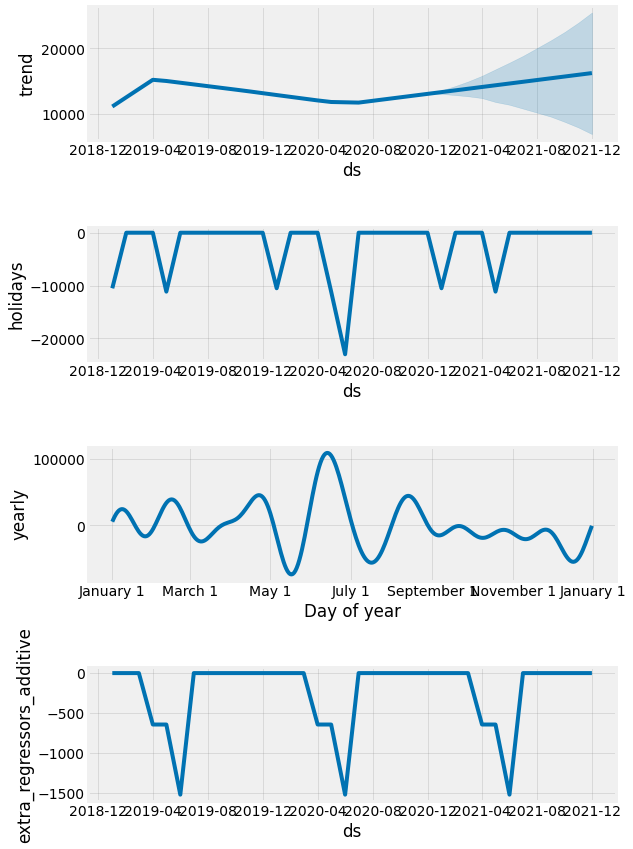

In [40]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

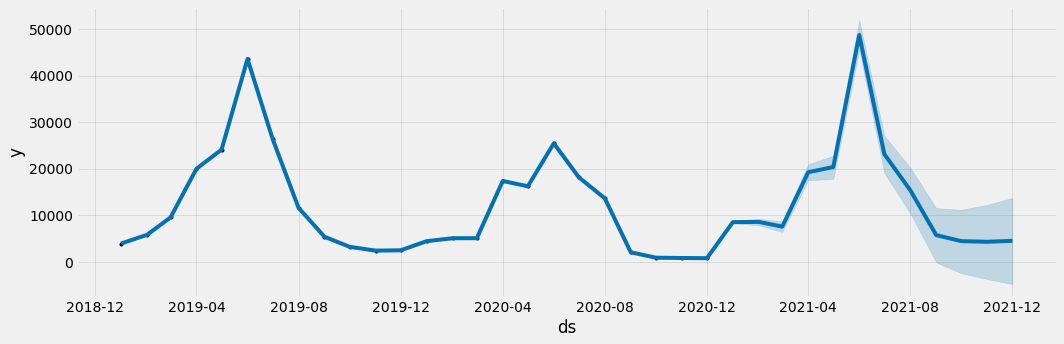

In [41]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [42]:
#X_tst['on_season'] = X_tst['ds'].apply(is_nfl_season)
#X_tst['off_season'] = ~X_tst['ds'].apply(is_nfl_season)
#X_tst['nfl_sunday'] = X_tst['ds'].apply(nfl_sunday)
X_tst['main_season'] = X_tst['ds'].apply(main_season)
X_tst['peak_season'] = X_tst['ds'].apply(peak_season)
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
5,2021-06-01,48737.646502,45167.706820,52079.133706
6,2021-07-01,23140.132516,18708.684367,27420.897488
7,2021-08-01,15387.799459,10013.233328,20685.480526
8,2021-09-01,5743.396955,-571.924441,12049.675525
9,2021-10-01,4446.420282,-3027.957457,11924.034655
10,2021-11-01,4315.744903,-4331.813700,12737.345742
11,2021-12-01,4515.348415,-5221.199010,14096.815168


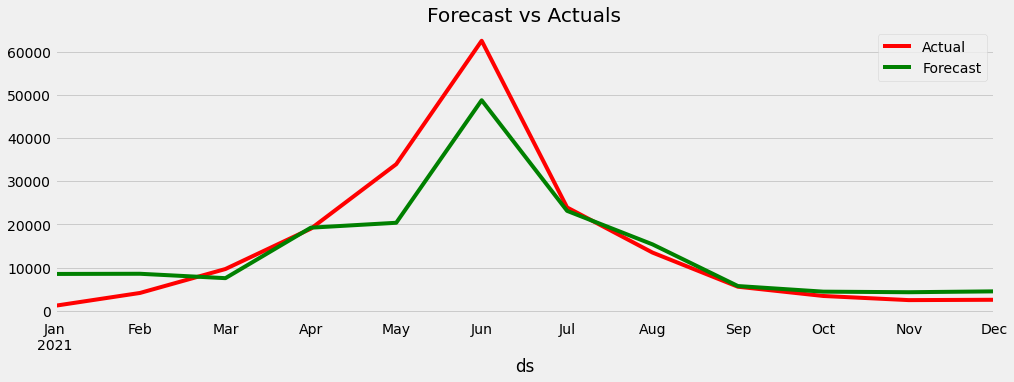

In [47]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [49]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 85.4377958503357


In [72]:
# Setup and train model with holidays
final_model_1 = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.2,
                      n_changepoints = 12,
                      seasonality_mode = 'additive',
                      #weekly_seasonality=True,
                      #daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model_1.add_country_holidays(country_name='DE')
#final_model.add_seasonality(name='monthly', period=30.5, fourier_order = 20)
final_model_1.add_regressor('main_season')
final_model_1.add_regressor('peak_season')
#final_model.add_seasonality(name='weekly_on_season', period=30.5, fourier_order=3, condition_name='on_season')
#final_model.add_seasonality(name='weekly_off_season', period=30.5, fourier_order=3, condition_name='off_season')
final_model_1.fit(X_tr)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/40mwa33z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkfqt7e3/bnjz40zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88899', 'data', 'file=/tmp/tmppkfqt7e3/40mwa33z.json', 'init=/tmp/tmppkfqt7e3/bnjz40zs.json', 'output', 'file=/tmp/tmp4bkms2lt/prophet_model-20220912222657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:26:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:27:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [73]:
future_1 = final_model_1.make_future_dataframe(periods=12, freq='MS')
future_1['main_season'] = future_1['ds'].apply(main_season)
future_1['peak_season'] = future_1['ds'].apply(peak_season)

#future['on_season'] = future['ds'].apply(is_nfl_season)
#future['off_season'] = ~future['ds'].apply(is_nfl_season) 
forecast_1 = final_model_1.predict(future_1)
forecast_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,7734.840600,7640.358960,7807.037760
25,2021-02-01,11256.519275,10986.690436,11491.086600
26,2021-03-01,6272.418108,5822.133830,6703.223738
27,2021-04-01,17894.720554,17225.587252,18524.389027
28,2021-05-01,18535.651807,17604.935382,19437.271484
29,2021-06-01,55289.814910,54094.845007,56418.854329
30,2021-07-01,20411.925053,19017.679462,21824.571423
31,2021-08-01,12515.038770,10792.106281,14246.668778
32,2021-09-01,2699.412507,668.352324,4746.409958
33,2021-10-01,1225.495835,-1088.891780,3645.396182


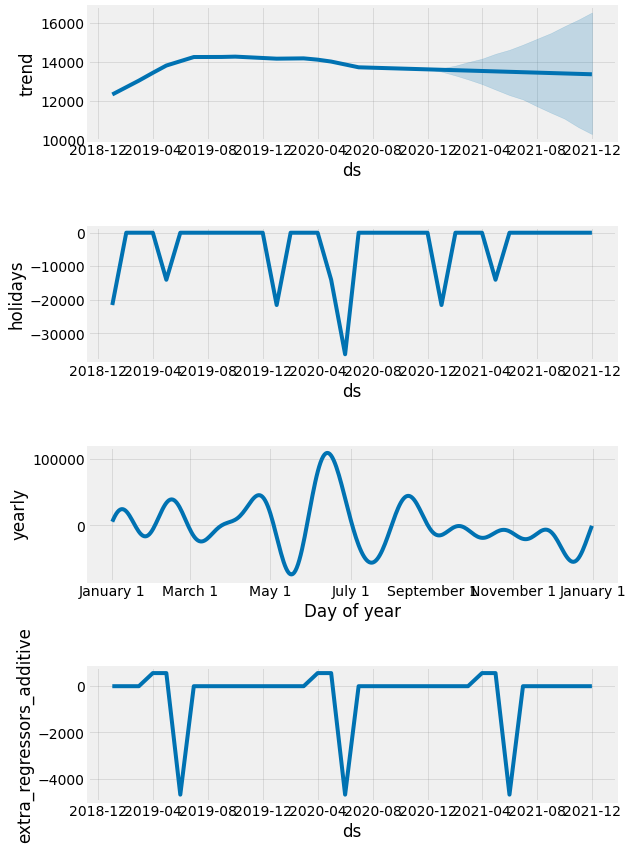

In [74]:
# Plot the components of the model
fig = final_model.plot_components(forecast_1)

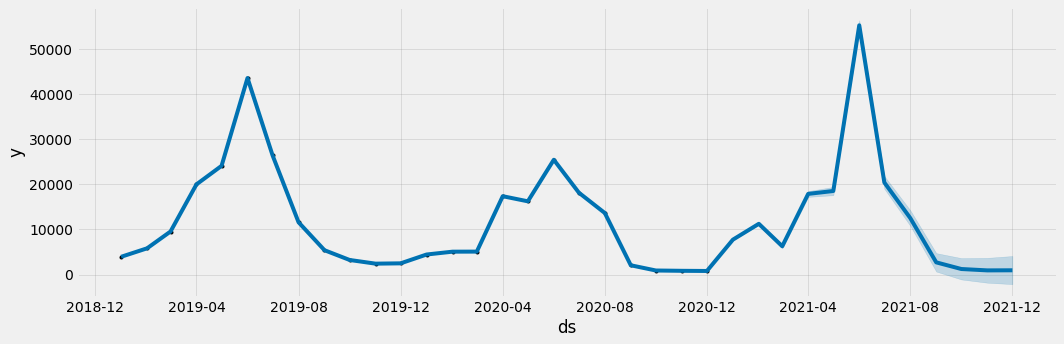

In [75]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast_1,ax=ax)
plt.show()

In [76]:
#X_tst['on_season'] = X_tst['ds'].apply(is_nfl_season)
#X_tst['off_season'] = ~X_tst['ds'].apply(is_nfl_season)
#X_tst['nfl_sunday'] = X_tst['ds'].apply(nfl_sunday)
X_tst['main_season'] = X_tst['ds'].apply(main_season)
X_tst['peak_season'] = X_tst['ds'].apply(peak_season)
X_tst_final_1= final_model_1.predict(X_tst)
X_tst_final_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
5,2021-06-01,55289.814910,53932.978935,56472.988776
6,2021-07-01,20411.925053,18767.638179,21950.201260
7,2021-08-01,12515.038770,10516.418156,14477.241886
8,2021-09-01,2699.412507,330.929342,5031.827438
9,2021-10-01,1225.495835,-1636.198858,3928.423275
10,2021-11-01,920.506197,-2296.794632,4030.655582
11,2021-12-01,942.541455,-2685.300963,4564.910504


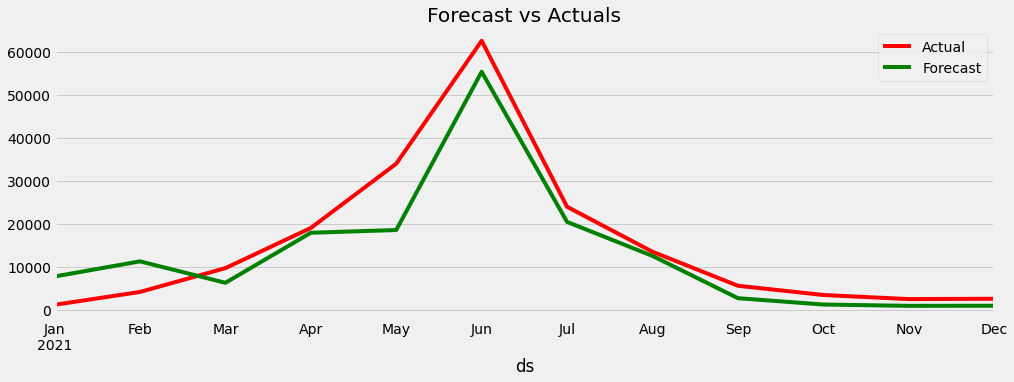

In [77]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final_1.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [78]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final_1['yhat']))
print('MAPE', MAPE)

MAPE 91.57564489494266


In [100]:
from pandasql import sqldf
mysql = lambda q: sqldf(q, globals()) 
query = ''' select X_tst.ds , X_tst.y , X_tst_final_1.yhat
from X_tst
inner join X_tst_final_1 on X_tst.ds=X_tst_final_1.ds
group by X_tst.ds''' 
mysql(query)

,ds,y,yhat
0,2021-01-01 00:00:00.000000,1163,7734.840600
1,2021-02-01 00:00:00.000000,4146,11256.519275
2,2021-03-01 00:00:00.000000,9682,6272.418108
3,2021-04-01 00:00:00.000000,19012,17894.720554
4,2021-05-01 00:00:00.000000,33941,18535.651807
5,2021-06-01 00:00:00.000000,62497,55289.814910
6,2021-07-01 00:00:00.000000,23930,20411.925053
7,2021-08-01 00:00:00.000000,13488,12515.038770
8,2021-09-01 00:00:00.000000,5587,2699.412507
9,2021-10-01 00:00:00.000000,3444,1225.495835


from the above, results, we can see there is significant improvement in MAPE. We can further improve the model by changing the fourier order of the seasonalities and by including more features and add them as additional regressors